In [1]:
import fastbook
fastbook.setup_book()

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.model_selection import KFold
import geopandas as gpd
import math


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


The following code segments are for running the historical analysis shown in figure 2 of the paper. The code does the following:

* Set input path to the data and an output path to where you want to save output data  
* Open data. The data used to run the model can be downloaded from: https://doi.org/10.5518/1152 

* Set dependent variable name
* Set simulation information
* Set years you would like to analyse 
* Loop over simulations and years and fit model to data in each simulation

Set inpath and outpath

In [2]:
# Path to the data.
inpath = '.../'

# Outpath where you would like to save output data.
outpath = '.../NNout/' 

Open data

In [3]:
df = pd.read_pickle(inpath + 'trainvalid.pkl')
df = pd.DataFrame(df)

In [4]:
df

FID  \
0      6938   
1      6939   
2      6940   
3      6941   
4      6942   
...     ...   
5126  29463   
5127  29657   
5128  29658   
5129  29659   
5130  29853   

                                                                                                            geometry  \
0     POLYGON ((-73.50000 -6.75000, -73.25000 -6.75000, -73.25000 -7.00000, -73.50000 -7.00000, -73.50000 -6.75000))   
1     POLYGON ((-73.50000 -7.00000, -73.25000 -7.00000, -73.25000 -7.25000, -73.50000 -7.25000, -73.50000 -7.00000))   
2     POLYGON ((-73.50000 -7.25000, -73.25000 -7.25000, -73.25000 -7.50000, -73.50000 -7.50000, -73.50000 -7.25000))   
3     POLYGON ((-73.50000 -7.50000, -73.25000 -7.50000, -73.25000 -7.75000, -73.50000 -7.75000, -73.50000 -7.50000))   
4     POLYGON ((-73.50000 -7.75000, -73.25000 -7.75000, -73.25000 -8.00000, -73.50000 -8.00000, -73.50000 -7.75000))   
...                                                                                                              ...   
5126  POLYGON ((-44.75000 -3.00000, -44.50000 -3.00000, -44.50000 -3.25000, -44.75000 -3.25000, -44.75000 -3.00000))   
5127  POLYGON ((-44.50000 -2.50000, -44.25000 -2.50000, -44.25000 -2.75000, -44.50000 -2.75000, -44.50000 -2.50000))   
5128  POLYGON ((-44.50000 -2.75000, -44.25000 -2.75000, -44.25000 -3.00000, -44.50000 -3.00000, -44.50000 -2.75000))   
5129  POLYGON ((-44.50000 -3.00000, -44.25000 -3.00000, -44.25000 -3.25000, -44.50000 -3.25000, -44.50000 -3.00000))   
5130  POLYGON ((-44.25000 -2.50000, -44.00000 -2.50000, -44.00000 -2.75000, -44.25000 -2.75000, -44.25000 -2.50000))   

                          centre     area_km    states  year  month  \
0     POINT (-73.37500 -6.87500)  763.931320  Amazonas  2003      1   
1     POINT (-73.37500 -7.12500)  763.532945  Amazonas  2003      1   
2     POINT (-73.37500 -7.37500)  763.120400      Acre  2003      1   
3     POINT (-73.37500 -7.62500)  762.693690      Acre  2003      1   
4     POINT (-73.37500 -7.87500)  762.252820      Acre  2003      1   
...                          ...         ...       ...   ...    ...   
5126  POINT (-44.62500 -3.12500)  768.202987  Maranhao  2020     12   
5127  POINT (-44.37500 -2.62500)  768.530736  Maranhao  2020     12   
5128  POINT (-44.37500 -2.87500)  768.373982  Maranhao  2020     12   
5129  POINT (-44.37500 -3.12500)  768.202987  Maranhao  2020     12   
5130  POINT (-44.12500 -2.62500)  768.530736  Maranhao  2020     12   

      fire_number     defor  t_month   p_6_month     p_month  pasture_frac  \
0             0.0  0.000000  28.2428  713.030685  268.399323         0.000   
1             0.0  1.357946  28.1812  756.387218  270.729797         0.001   
2             0.0  8.050515  28.3756  779.980492  248.937378         0.017   
3             0.0  4.219792  27.8924  805.984306  234.089584         0.005   
4             0.0  3.456357  27.2764  810.648941  218.884186         0.003   
...           ...       ...      ...         ...         ...           ...   
5126          0.0  0.000000  30.4916  333.955908  135.318237         0.050   
5127          0.0  0.924999  29.5052  351.155690   92.066948         0.043   
5128          0.0  0.232154  28.4492  366.457522  118.020523         0.053   
5129          0.0  1.950259  30.0412  328.087385  146.691986         0.255   
5130          0.0  0.503407  30.6444  325.144393   89.317810         0.089   

      crop_frac  savanna_frac  lai_12_month_mean  
0         0.000         0.000           5.258945  
1         0.000         0.000           5.231799  
2         0.000         0.000           5.270495  
3         0.000         0.000           5.223077  
4         0.000         0.000           5.252493  
...         ...           ...                ...  
5126      0.006         0.487           1.794112  
5127      0.001         0.008           2.633466  
5128      0.001         0.085           2.791391  
5129      0.002         0.200           2.445894  
5130      0.001         0.002      

Print features/variable names. Refer to data README file for a description of variables.

In [5]:
df.columns

Index(['FID', 'geometry', 'centre', 'area_km', 'states', 'year', 'month',
       'fire_number', 'defor', 't_month', 'p_6_month', 'p_month',
       'pasture_frac', 'crop_frac', 'savanna_frac', 'lai_12_month_mean'],
      dtype='object')

Set dependent variable name

In [6]:
dep_var = 'fire_number'

Resacale featues that we will use in the simultaions.

In [7]:
df['defor'] = df['defor'] / df['area_km'] 
df['defor'] = (df['defor'] - df['defor'].min())/(df['defor'].max() - df['defor'].min())
df['p_month'] = (df['p_month'] - df['p_month'].min())/(df['p_month'].max() - df['p_month'].min())
df['t_month'] = (df['t_month'] - df['t_month'].min())/(df['t_month'].max() - df['t_month'].min())
df['p_6_month'] = (df['p_6_month'] - df['p_6_month'].min())/(df['p_6_month'].max() - df['p_6_month'].min())
df['lai_12_month_mean'] = (df['lai_12_month_mean'] - df['lai_12_month_mean'].min())/(df['lai_12_month_mean'].max() - df['lai_12_month_mean'].min())

Set simulation information: 

* 'to_drop': features to drop 
* 'sim_label': label used to save predictions for each simulation. 

Refer to paper for details about each simulation. 

In [8]:
sim_label = [
    'Sim_Clim+Def',
    'Sim_Clim',
    'Sim_Clim+LU',
    'Sim_Clim+LU+Def'
]

sim_features = [
    
    ['fire_number', 'defor', 't_month', 'p_6_month', 'p_month','lai_12_month_mean', 'year'], # 'Sim_Clim+Def'
    
    ['fire_number', 't_month', 'p_6_month', 'p_month','lai_12_month_mean', 'year'],          # 'Sim_Clim'
    
    ['fire_number', 't_month', 'p_6_month', 'p_month','lai_12_month_mean',                   # 'Sim_Clim+LU'
     'pasture_frac', 'crop_frac', 'savanna_frac', 'year'], 
    
    ['fire_number', 'defor', 't_month', 'p_6_month', 'p_month','lai_12_month_mean',          # 'Sim_Clim+LU+Def'
     'pasture_frac', 'crop_frac', 'savanna_frac', 'year']
    
]


Set years you would like to analyse. Years allowed 2003 to 2020.

In [9]:
years = np.arange(2003,2021,1)

Set RMSE function and procs_nn

In [10]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

procs_nn = [Categorify, FillMissing, Normalize]

Loop over simulations and years and fit model to data in each simulation

Sim_Clim+Def
2003
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.999814


Test RMSE = 8.179683
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.141854


Test RMSE = 8.183546
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.417861


Test RMSE = 8.128738
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.249612


Test RMSE = 8.161942
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.697895


Test RMSE = 8.151561
2004
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.87647


Test RMSE = 9.723022
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.966851


Test RMSE = 9.676189
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.266518


Test RMSE = 9.725557
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.137643


Test RMSE = 9.663021
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.706836


Test RMSE = 9.763114
2005
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.737931


Test RMSE = 11.297088
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.856596


Test RMSE = 11.258321
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.200836


Test RMSE = 11.396446
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.911127


Test RMSE = 11.238913
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.546687


Test RMSE = 11.300422
2006
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.140637


Test RMSE = 7.667718
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.21683


Test RMSE = 7.507661
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.351216


Test RMSE = 7.483759
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.232629


Test RMSE = 7.520565
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.815261


Test RMSE = 7.60652
2007
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:262: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


Valid RMSE = 6.837995


Test RMSE = 11.240381
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.982642


Test RMSE = 11.282631
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.917479


Test RMSE = 11.30504
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.90696


Test RMSE = 11.350886
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.61441


Test RMSE = 11.235248
2008
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.255004


Test RMSE = 6.365601
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.361398


Test RMSE = 6.2762
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.173717


Test RMSE = 6.337824
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.278692


Test RMSE = 6.356418
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.002878


Test RMSE = 6.364556
2009
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.309909


Test RMSE = 5.141333
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.373677


Test RMSE = 5.240138
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.237214


Test RMSE = 5.168079
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.349755


Test RMSE = 5.152354
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.043538


Test RMSE = 5.162957
2010
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.871161


Test RMSE = 12.004695
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.723594


Test RMSE = 11.931275
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.674906


Test RMSE = 11.960956
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.830543


Test RMSE = 11.982366
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.778751


Test RMSE = 11.938628
2011
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.275949


Test RMSE = 3.481325
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.33856


Test RMSE = 3.51103
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.320743


Test RMSE = 3.519229
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.208392


Test RMSE = 3.513087
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.439832


Test RMSE = 3.55861
2012
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.233941


Test RMSE = 5.044246
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.291259


Test RMSE = 5.051334
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.243162


Test RMSE = 5.057664
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.174776


Test RMSE = 5.0564
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.346206


Test RMSE = 5.06137
2013
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.297103


Test RMSE = 2.837564
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.361009


Test RMSE = 2.834735
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.348361


Test RMSE = 2.831513
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.238655


Test RMSE = 2.838239
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.42913


Test RMSE = 2.831478
2014
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.248327


Test RMSE = 4.270389
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.309933


Test RMSE = 4.320249
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.312401


Test RMSE = 4.289105
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.175253


Test RMSE = 4.304801
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.410096


Test RMSE = 4.319351
2015
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.15174


Test RMSE = 5.974242
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.264135


Test RMSE = 5.970777
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.244876


Test RMSE = 5.962046
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.133907


Test RMSE = 5.960779
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.352382


Test RMSE = 5.919561
2016
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.1456


Test RMSE = 5.81503
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.276459


Test RMSE = 5.819458
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.282673


Test RMSE = 5.829489
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.112206


Test RMSE = 5.757913
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.359949


Test RMSE = 5.753767
2017
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.066038


Test RMSE = 6.659014
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.258762


Test RMSE = 6.671151
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.206439


Test RMSE = 6.643439
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.106589


Test RMSE = 6.641542
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.326513


Test RMSE = 6.63673
2018
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.185516


Test RMSE = 4.147663
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.348709


Test RMSE = 4.174181
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.288504


Test RMSE = 4.147626
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.249455


Test RMSE = 4.198142
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.409468


Test RMSE = 4.191366
2019
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.041077


Test RMSE = 7.043334
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.224845


Test RMSE = 7.03595
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.151057


Test RMSE = 7.033856
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.140139


Test RMSE = 7.054831
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.313907


Test RMSE = 7.021541
2020
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.060967


Test RMSE = 6.568298
1
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.253592


Test RMSE = 6.554273
2
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.21825


Test RMSE = 6.505712
3
length of cont 5
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.103469


Test RMSE = 6.612675
4
length of cont 5
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.374719


Test RMSE = 6.481227
Sim_Clim
2003
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.23004


Test RMSE = 9.812074
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.471933


Test RMSE = 9.859171
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.942083


Test RMSE = 9.863386
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.697639


Test RMSE = 9.856689
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.022133


Test RMSE = 9.869388
2004
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.040845


Test RMSE = 12.575915
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.197399


Test RMSE = 12.560614
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.677487


Test RMSE = 12.568046
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.543381


Test RMSE = 12.52477
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.953687


Test RMSE = 12.548582
2005
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.802255


Test RMSE = 14.919104
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.021854


Test RMSE = 14.876121
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.495321


Test RMSE = 14.989045
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.170645


Test RMSE = 14.952864
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.731898


Test RMSE = 14.964662
2006
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.403599


Test RMSE = 9.369239
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.558645


Test RMSE = 9.353831
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.842889


Test RMSE = 9.372985
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.673592


Test RMSE = 9.368201
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.164528


Test RMSE = 9.355281
2007
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.113829


Test RMSE = 13.671013
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.261503


Test RMSE = 13.615285
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.324135


Test RMSE = 13.635951
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.308345


Test RMSE = 13.641361
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.939538


Test RMSE = 13.614674
2008
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.648371


Test RMSE = 6.55117
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.782175


Test RMSE = 6.550629
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.693828


Test RMSE = 6.576107
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.802178


Test RMSE = 6.570249
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.451036


Test RMSE = 6.551003
2009
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.730515


Test RMSE = 4.959531
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.822457


Test RMSE = 4.910326
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.766268


Test RMSE = 4.926797
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.842241


Test RMSE = 4.968263
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.480166


Test RMSE = 4.913266
2010
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.321767


Test RMSE = 12.550653
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.213562


Test RMSE = 12.504176
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.253575


Test RMSE = 12.545437
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.35217


Test RMSE = 12.564312
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.252617


Test RMSE = 12.561957
2011
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.674524


Test RMSE = 4.562924
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.754125


Test RMSE = 4.435414
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.797353


Test RMSE = 4.504642
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.674296


Test RMSE = 4.551208
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.824412


Test RMSE = 4.53561
2012
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.641826


Test RMSE = 6.085309
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.7018


Test RMSE = 6.098611
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.735175


Test RMSE = 6.093014
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.642467


Test RMSE = 6.080194
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.738972


Test RMSE = 6.063798
2013
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.709157


Test RMSE = 3.420352
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.787482


Test RMSE = 3.40438
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.828928


Test RMSE = 3.368902
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.727061


Test RMSE = 3.451884
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.822986


Test RMSE = 3.406413
2014
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.658091


Test RMSE = 5.023691
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.742227


Test RMSE = 5.057579
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.793581


Test RMSE = 5.037553
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.661774


Test RMSE = 5.035531
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.790328


Test RMSE = 5.051017
2015
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.530762


Test RMSE = 7.527562
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.65981


Test RMSE = 7.594498
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.681215


Test RMSE = 7.405414
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.571447


Test RMSE = 7.519068
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.688941


Test RMSE = 7.67755
2016
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.57632


Test RMSE = 7.036395
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.687486


Test RMSE = 7.107187
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.769619


Test RMSE = 7.012984
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.576426


Test RMSE = 7.003719
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.687387


Test RMSE = 6.974035
2017
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.508479


Test RMSE = 7.152384
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.728049


Test RMSE = 7.172898
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.721714


Test RMSE = 7.143839
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.598937


Test RMSE = 7.197716
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.677602


Test RMSE = 7.132236
2018
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.608002


Test RMSE = 5.115631
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.800311


Test RMSE = 5.062642
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.805881


Test RMSE = 5.104637
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.695257


Test RMSE = 5.106962
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.76574


Test RMSE = 5.098786
2019
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.425041


Test RMSE = 8.179232
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.646416


Test RMSE = 8.236902
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.663374


Test RMSE = 8.180447
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.569783


Test RMSE = 8.242709
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.634497


Test RMSE = 8.235813
2020
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.478241


Test RMSE = 7.55914
1
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.715411


Test RMSE = 7.467303
2
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.748563


Test RMSE = 7.497969
3
length of cont 4
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.55581


Test RMSE = 7.462162
4
length of cont 4
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.688375


Test RMSE = 7.413731
Sim_Clim+LU
2003
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.622705


Test RMSE = 9.172561
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.930933


Test RMSE = 9.240763
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.320128


Test RMSE = 9.166233
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.020278


Test RMSE = 9.174401
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.392629


Test RMSE = 9.170568
2004
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.432319


Test RMSE = 11.826657
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.697114


Test RMSE = 11.873546
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.054801


Test RMSE = 11.869281
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.888014


Test RMSE = 11.886787
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.329125


Test RMSE = 11.805844
2005
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.168075


Test RMSE = 14.045465
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.534311


Test RMSE = 13.900375
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.897688


Test RMSE = 14.056441
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.51103


Test RMSE = 13.976611
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.132422


Test RMSE = 13.956627
2006
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.742077


Test RMSE = 8.617068
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.017456


Test RMSE = 8.639261
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.223049


Test RMSE = 8.743036
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.994698


Test RMSE = 8.641336
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.536302


Test RMSE = 8.648294
2007
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.516984


Test RMSE = 12.46175
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.746491


Test RMSE = 12.399776
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.749406


Test RMSE = 12.483997
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.673216


Test RMSE = 12.472634
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.388261


Test RMSE = 12.45617
2008
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.977679


Test RMSE = 6.275423
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.227433


Test RMSE = 6.308355
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.018241


Test RMSE = 6.294914
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.101728


Test RMSE = 6.278372
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.7957


Test RMSE = 6.307427
2009
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.038093


Test RMSE = 4.638497
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.247642


Test RMSE = 4.656205
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.126281


Test RMSE = 4.612459
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.135183


Test RMSE = 4.691786
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.822243


Test RMSE = 4.705922
2010
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.694673


Test RMSE = 11.671042
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.664202


Test RMSE = 11.605029
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.581308


Test RMSE = 11.665207
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.705652


Test RMSE = 11.688447
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.601553


Test RMSE = 11.570154
2011
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.979641


Test RMSE = 5.001698
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.169244


Test RMSE = 5.338548
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.101365


Test RMSE = 5.030961
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.982855


Test RMSE = 5.043375
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.128158


Test RMSE = 5.193934
2012
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.968929


Test RMSE = 6.225179
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.126897


Test RMSE = 6.277856
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.042039


Test RMSE = 6.33302
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.943422


Test RMSE = 6.448314
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.055565


Test RMSE = 6.173014
2013
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.028176


Test RMSE = 3.480799
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.218032


Test RMSE = 3.500401
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.127182


Test RMSE = 3.487375
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.054476


Test RMSE = 3.482859
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.149584


Test RMSE = 3.48067
2014
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.987551


Test RMSE = 4.857669
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.193942


Test RMSE = 4.886464
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.098889


Test RMSE = 4.827326
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.980166


Test RMSE = 4.853763
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.104756


Test RMSE = 4.85917
2015
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.897311


Test RMSE = 6.899909
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.101804


Test RMSE = 6.930852
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.027162


Test RMSE = 6.886082
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.912686


Test RMSE = 6.79937
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.033354


Test RMSE = 6.90972
2016
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.90971


Test RMSE = 7.038858
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.120918


Test RMSE = 7.04332
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.094556


Test RMSE = 7.376289
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.887695


Test RMSE = 6.852495
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.036414


Test RMSE = 6.873281
2017
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.865148


Test RMSE = 6.695742
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.135354


Test RMSE = 6.694786
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.048113


Test RMSE = 6.670264
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.948228


Test RMSE = 6.685736
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.039001


Test RMSE = 6.650471
2018
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.965111


Test RMSE = 4.48805
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.216537


Test RMSE = 4.494679
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.121109


Test RMSE = 4.469996
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.029507


Test RMSE = 4.463499
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.122367


Test RMSE = 4.472091
2019
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.818416


Test RMSE = 7.52924
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.057281


Test RMSE = 7.552543
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.0323


Test RMSE = 7.565163
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.941076


Test RMSE = 7.606142
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.00272


Test RMSE = 7.518204
2020
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.820354


Test RMSE = 7.158313
1
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.124176


Test RMSE = 7.057083
2
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 8.050682


Test RMSE = 7.101329
3
length of cont 7
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 7.914844


Test RMSE = 7.277518
4
length of cont 7
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 8.038865


Test RMSE = 7.142938
Sim_Clim+LU+Def
2003
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.58413


Test RMSE = 7.956004
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.816605


Test RMSE = 7.991656
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.978929


Test RMSE = 7.977313
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.749956


Test RMSE = 7.936342
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.320578


Test RMSE = 7.965181
2004
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.497968


Test RMSE = 9.246983
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.668266


Test RMSE = 9.154581
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.895315


Test RMSE = 9.208131
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.646027


Test RMSE = 9.172472
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.343135


Test RMSE = 9.260592
2005
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.37053


Test RMSE = 10.629905
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.5287


Test RMSE = 10.7222
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.821867


Test RMSE = 10.790306
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.438543


Test RMSE = 10.710215
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.20195


Test RMSE = 10.699219
2006
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.710784


Test RMSE = 7.377926
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.847404


Test RMSE = 7.107985
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.936055


Test RMSE = 7.259399
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.761632


Test RMSE = 7.350942
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.459201


Test RMSE = 7.42059
2007
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.443422


Test RMSE = 10.614473
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.595864


Test RMSE = 10.49518
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.619582


Test RMSE = 10.501772
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.482536


Test RMSE = 10.609023
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.303036


Test RMSE = 10.597629
2008
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.815911


Test RMSE = 6.493059
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.950559


Test RMSE = 6.271676
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.792376


Test RMSE = 6.388211
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.79433


Test RMSE = 6.429101
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.630643


Test RMSE = 6.424122
2009
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.864573


Test RMSE = 4.825899
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.962466


Test RMSE = 4.943923
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.850994


Test RMSE = 4.879031
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.83735


Test RMSE = 5.054692
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.700698


Test RMSE = 4.946767
2010
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.4812


Test RMSE = 11.313222
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.375455


Test RMSE = 11.292015
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.334478


Test RMSE = 11.369822
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.46901


Test RMSE = 11.322734
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.45315


Test RMSE = 11.30858
2011
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.851876


Test RMSE = 3.467789
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.953636


Test RMSE = 3.61069
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.928351


Test RMSE = 3.57174
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.782815


Test RMSE = 3.526477
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.043151


Test RMSE = 3.561244
2012
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.800041


Test RMSE = 4.930121
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.915286


Test RMSE = 4.942707
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.873686


Test RMSE = 4.951434
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.763324


Test RMSE = 5.007479
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.966381


Test RMSE = 4.960037
2013
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.860477


Test RMSE = 2.72855
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.996297


Test RMSE = 2.699664
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.962431


Test RMSE = 2.696748
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.819994


Test RMSE = 2.701509
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.028414


Test RMSE = 2.695462
2014
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.803207


Test RMSE = 4.218745
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.92522


Test RMSE = 4.193885
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.93777


Test RMSE = 4.1905
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.74658


Test RMSE = 4.171737
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.009873


Test RMSE = 4.14786
2015
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.713491


Test RMSE = 5.747094
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.877204


Test RMSE = 5.735944
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.872362


Test RMSE = 5.811966
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.706076


Test RMSE = 5.737982
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.934913


Test RMSE = 5.743182
2016
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.743064


Test RMSE = 5.934338
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.86804


Test RMSE = 6.150399
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.910118


Test RMSE = 6.167272
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.671543


Test RMSE = 5.833249
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.937602


Test RMSE = 5.92283
2017
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.690219


Test RMSE = 6.129213
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.906218


Test RMSE = 6.062743
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.854595


Test RMSE = 6.067268
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.718359


Test RMSE = 6.030768
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.929793


Test RMSE = 6.013461
2018
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.790917


Test RMSE = 3.692996
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.996692


Test RMSE = 3.714341
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.935626


Test RMSE = 3.654746
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.836513


Test RMSE = 3.658568
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 7.00861


Test RMSE = 3.663151
2019
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.631909


Test RMSE = 6.825883
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.788771


Test RMSE = 6.832754
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.802691


Test RMSE = 6.836347
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.692247


Test RMSE = 6.860158
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.936957


Test RMSE = 6.908714
2020
0


/nfs/b0122/Users/eeeeb/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.682725


Test RMSE = 6.440582
1
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.892938


Test RMSE = 6.357481
2
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.824895


Test RMSE = 6.39992
3
length of cont 8
length of cat 0
length of train set 837379
length of valid set 209345


Valid RMSE = 6.702924


Test RMSE = 6.34447
4
length of cont 8
length of cat 0
length of train set 837380
length of valid set 209344


Valid RMSE = 6.981854


Test RMSE = 6.277889


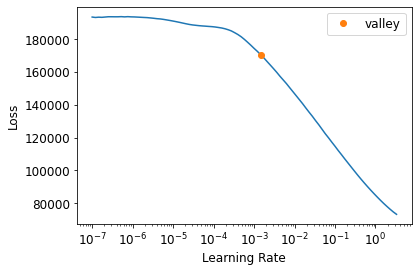

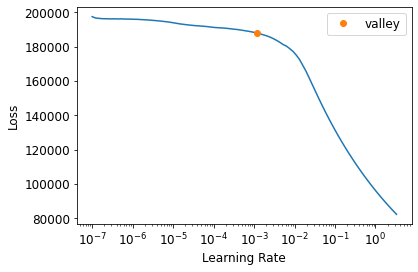

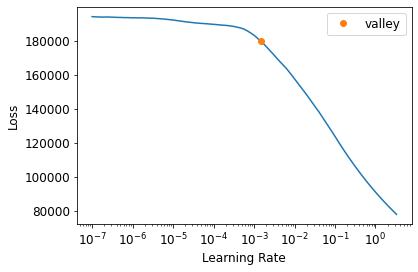

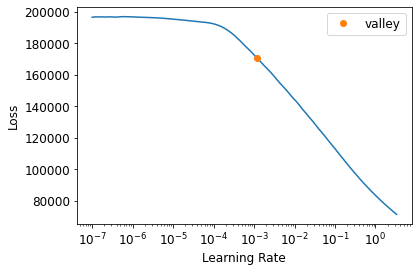

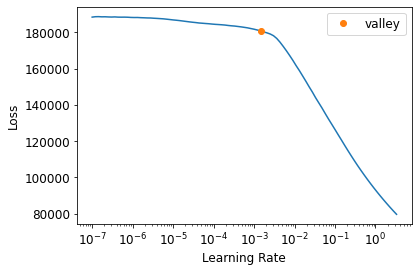

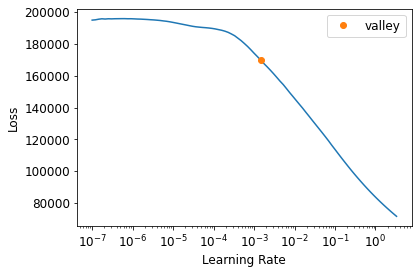

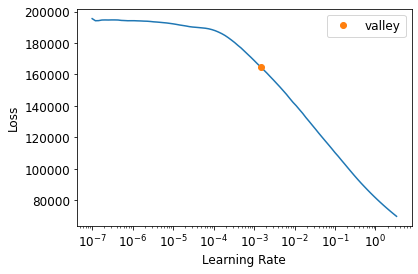

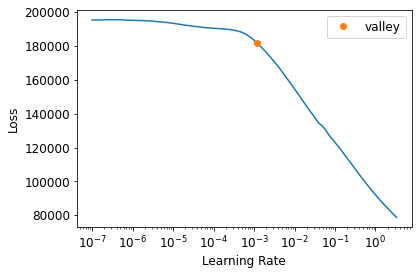

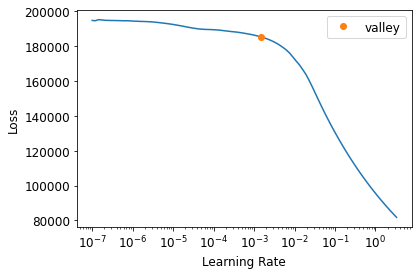

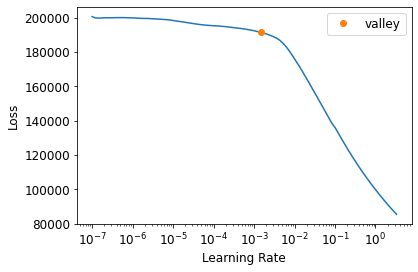

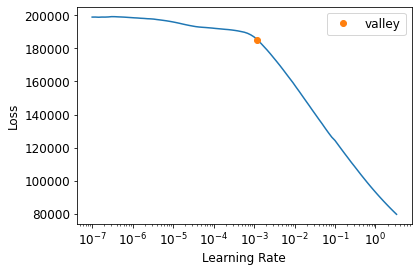

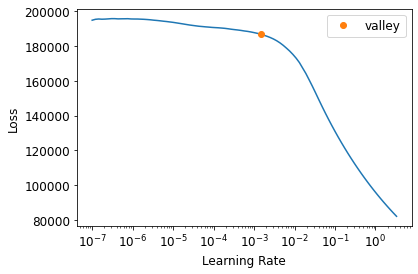

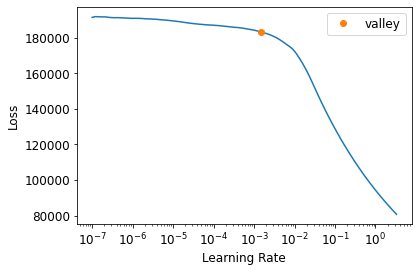

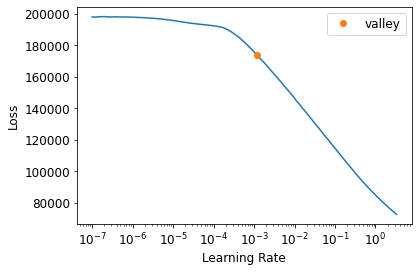

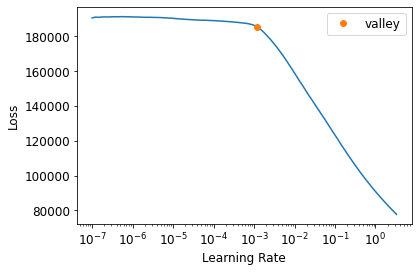

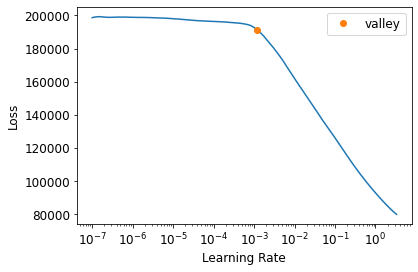

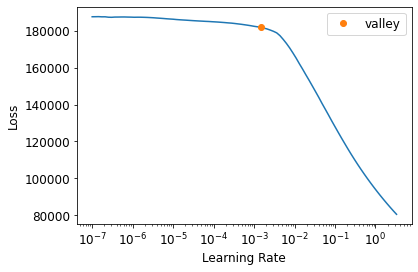

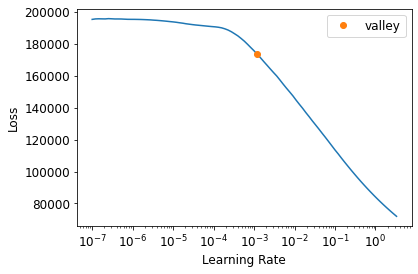

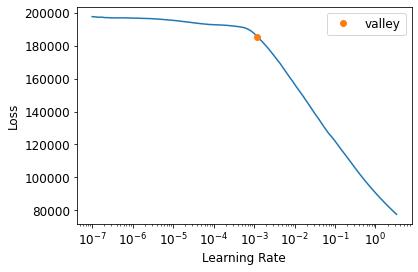

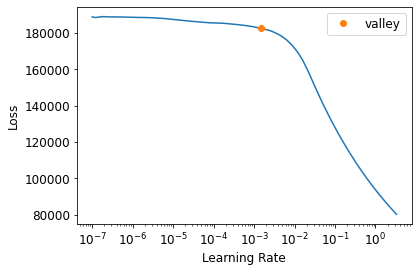

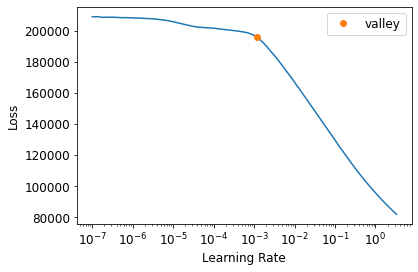

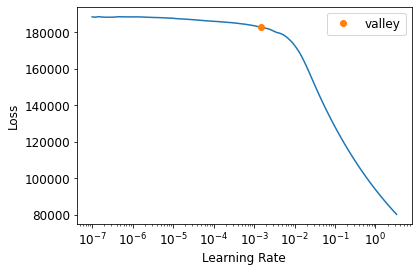

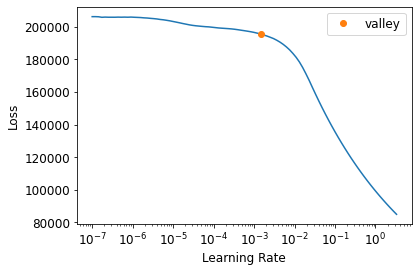

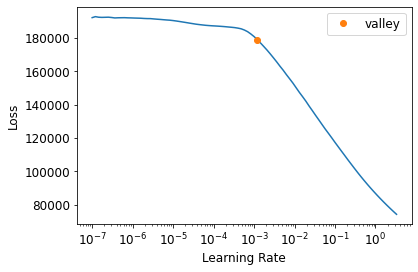

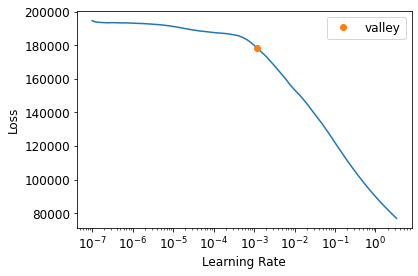

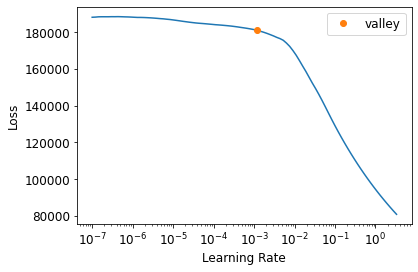

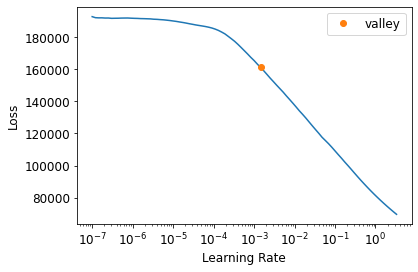

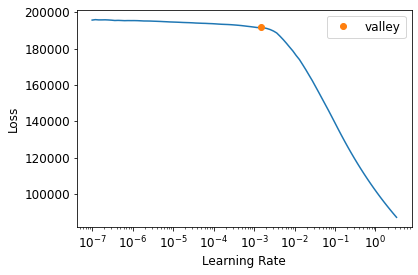

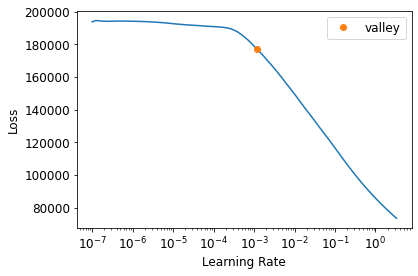

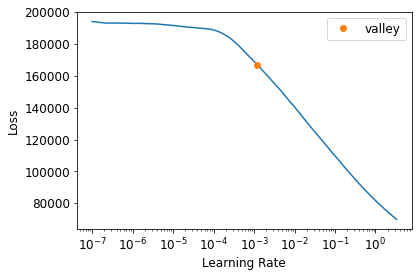

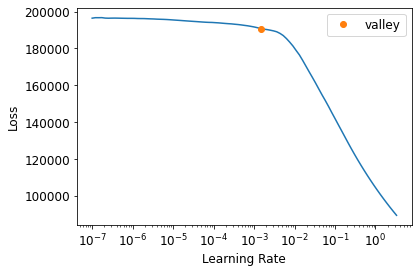

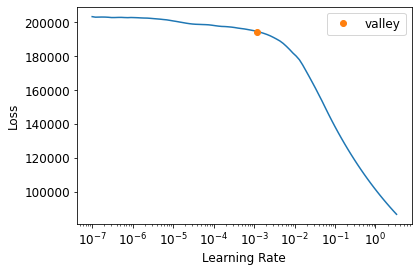

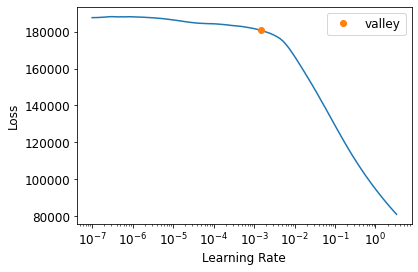

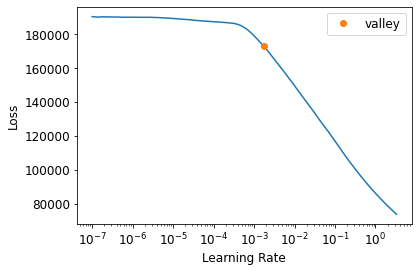

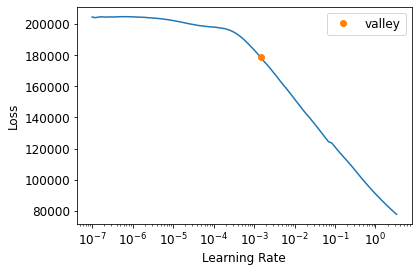

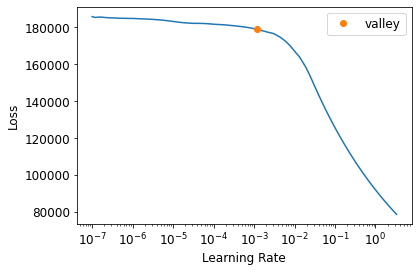

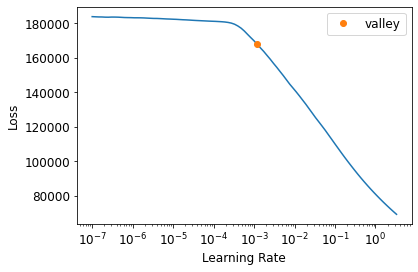

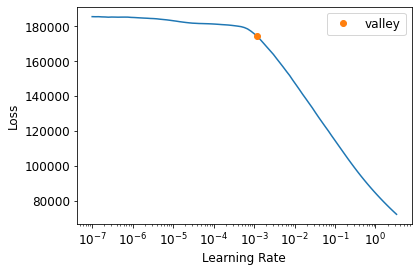

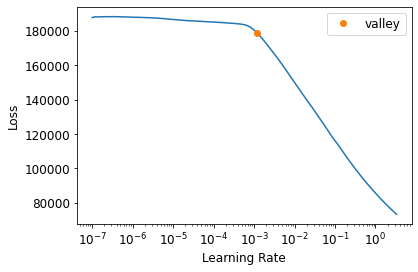

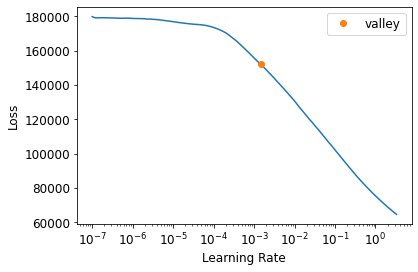

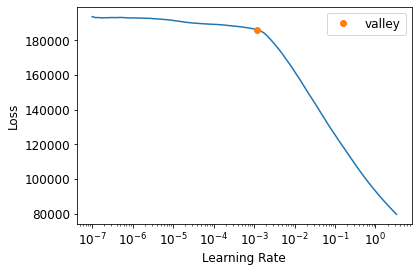

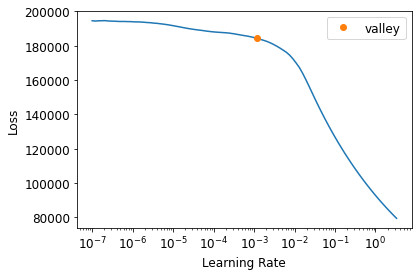

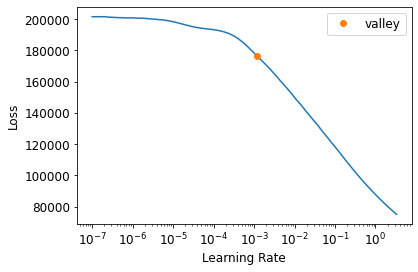

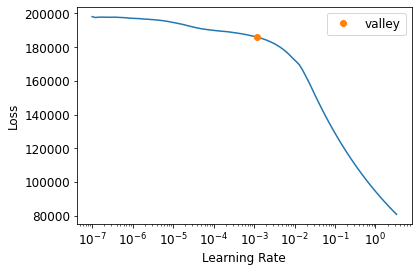

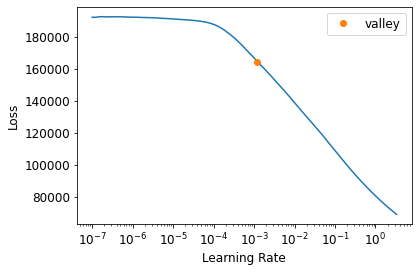

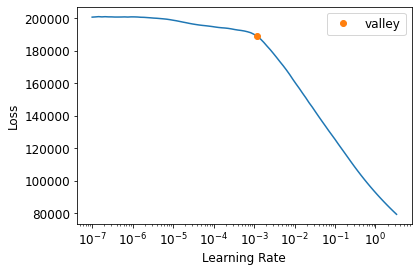

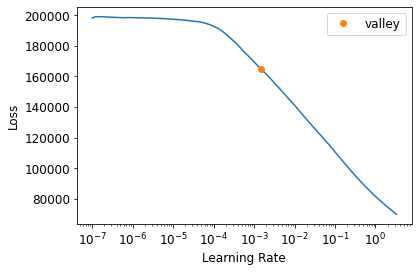

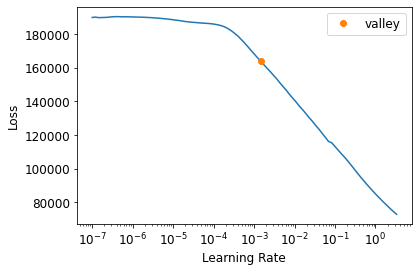

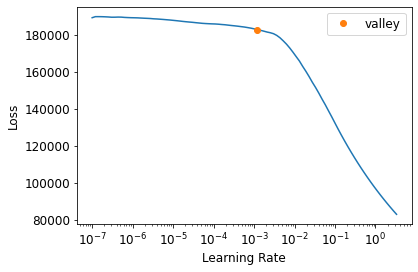

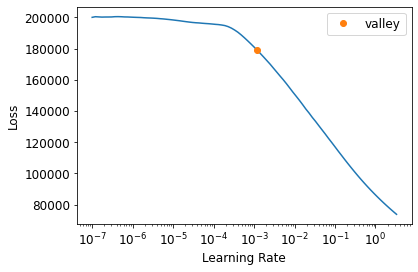

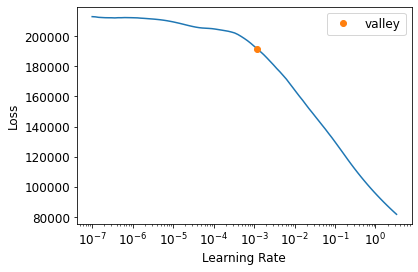

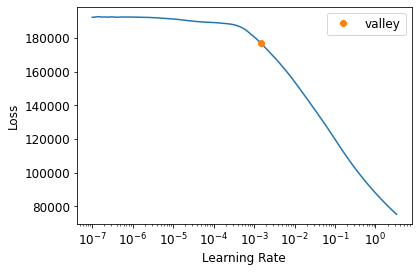

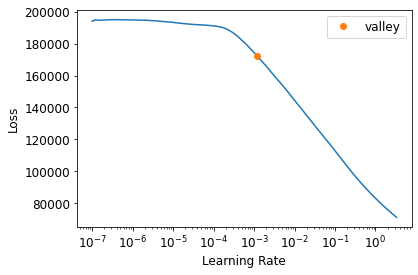

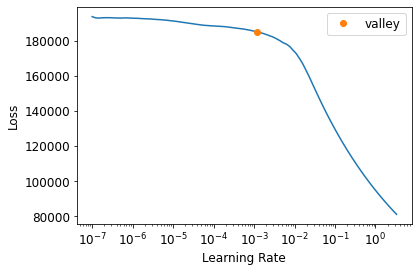

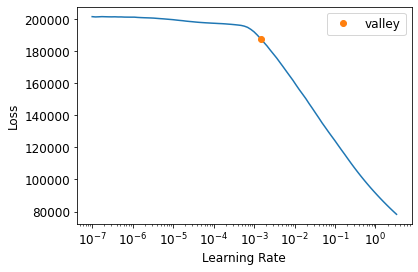

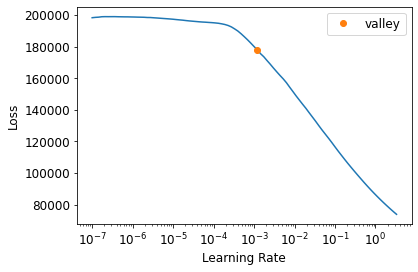

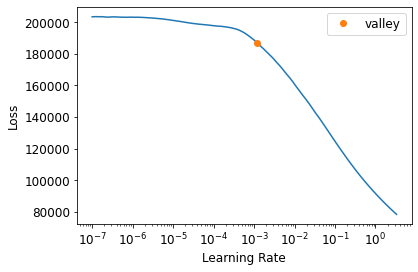

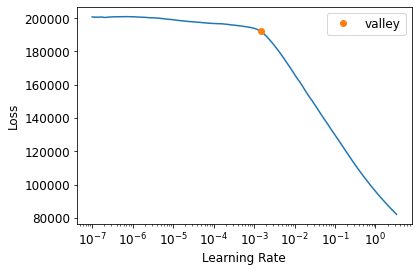

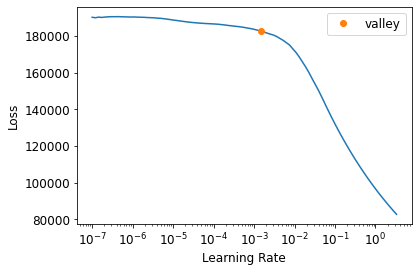

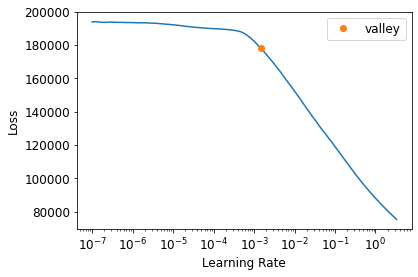

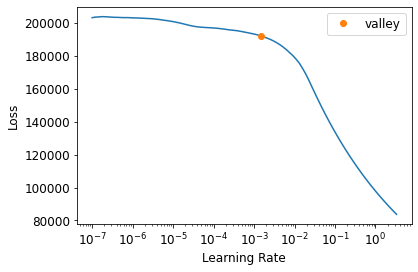

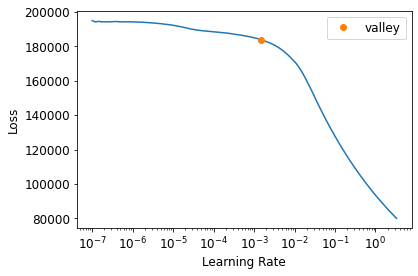

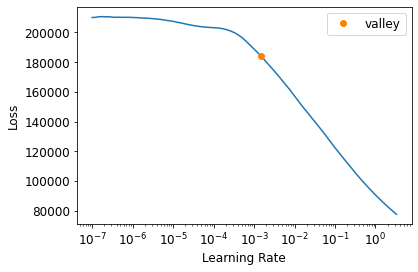

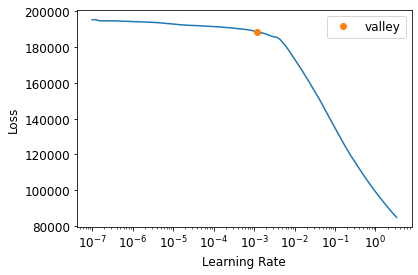

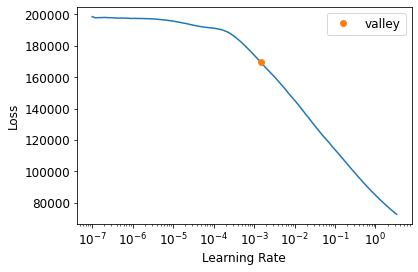

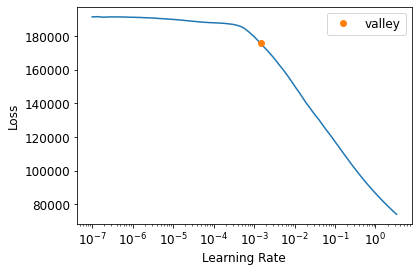

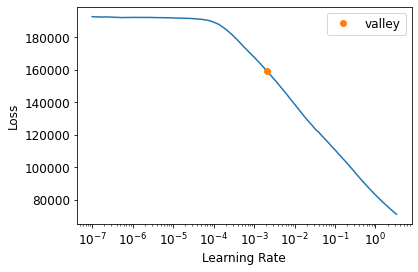

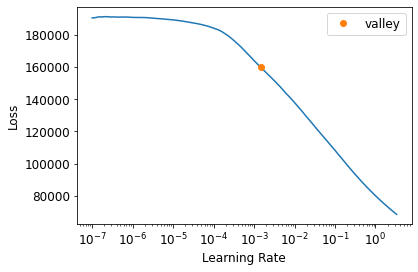

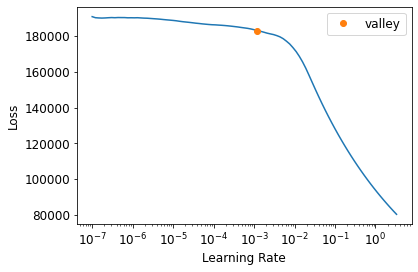

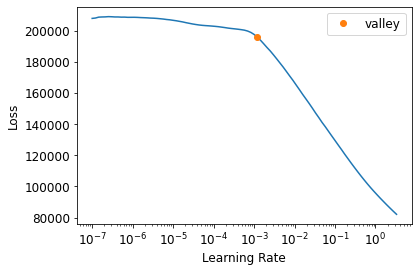

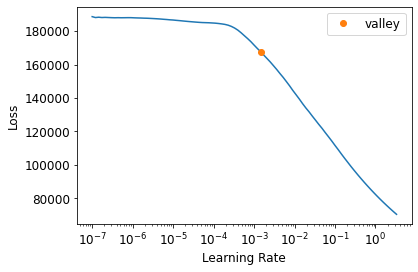

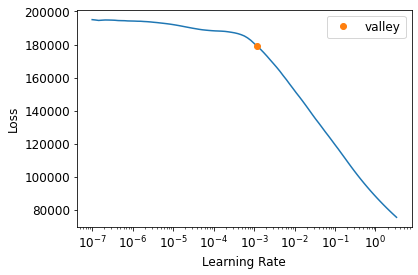

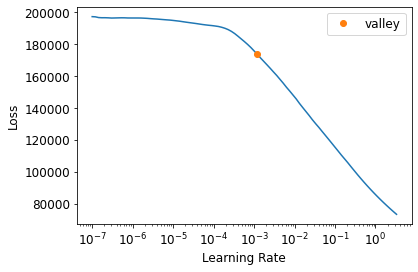

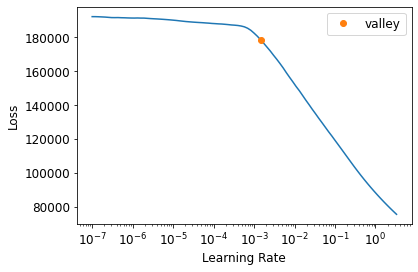

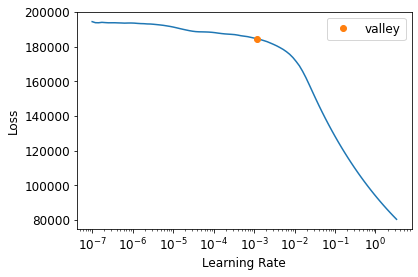

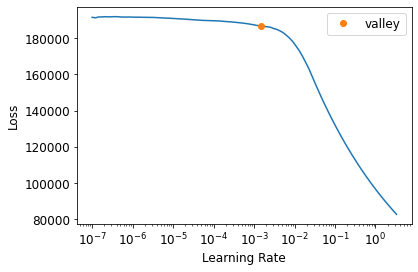

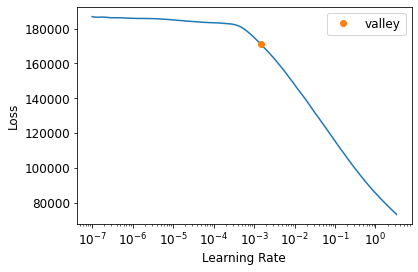

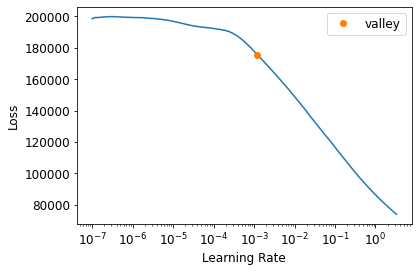

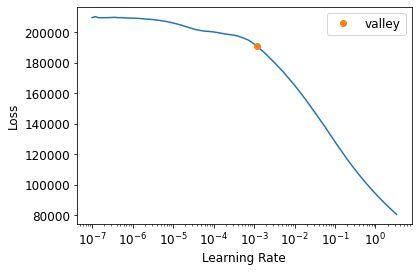

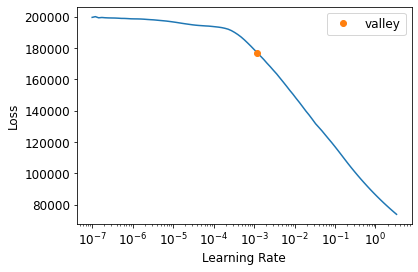

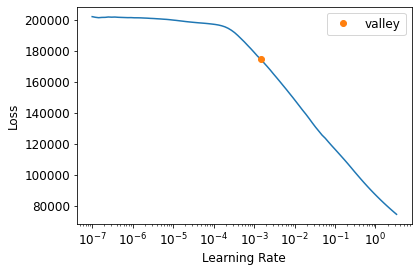

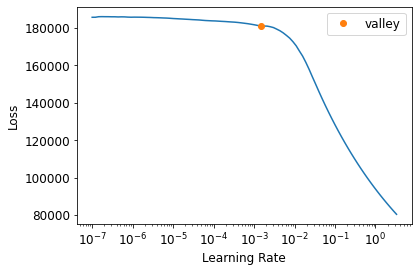

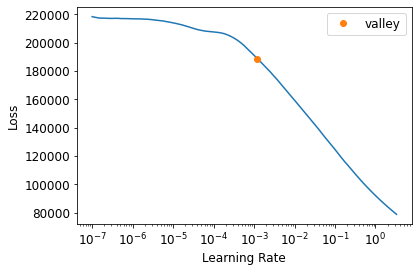

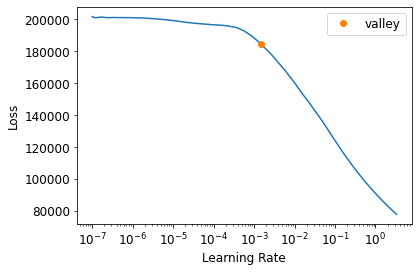

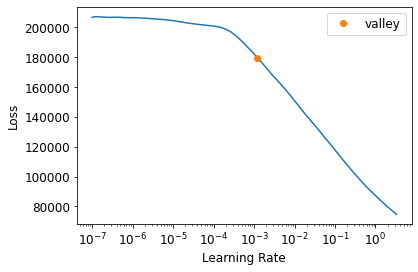

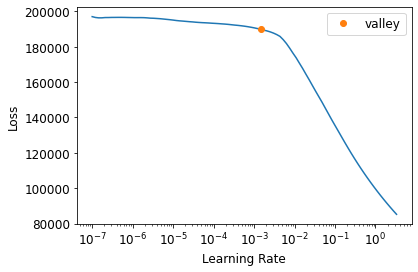

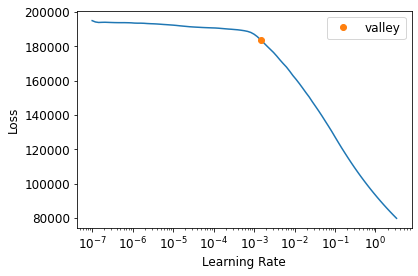

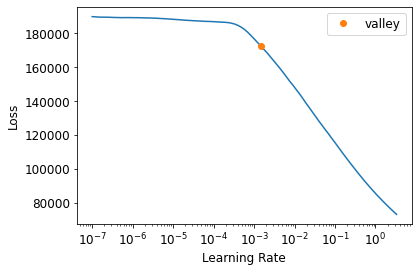

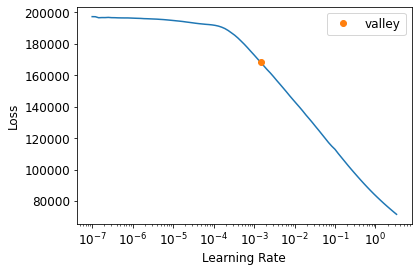

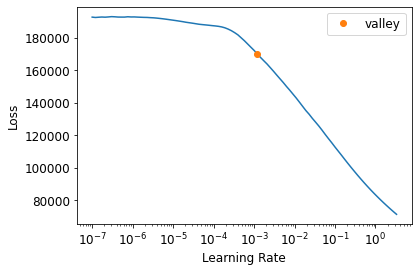

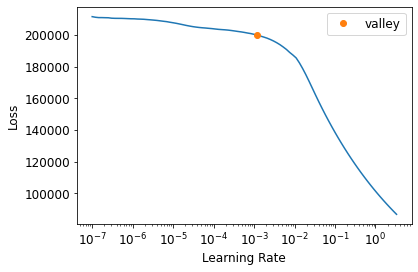

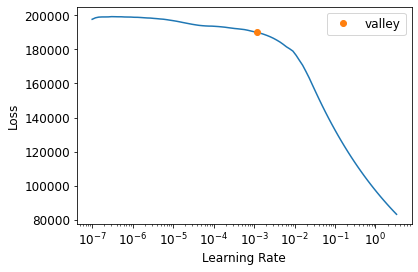

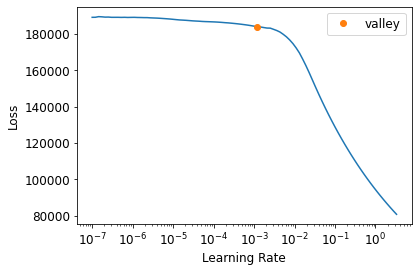

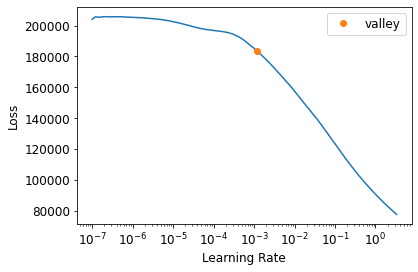

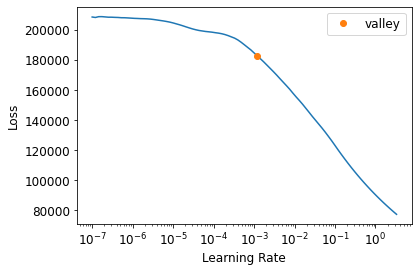

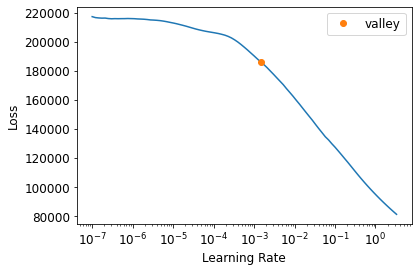

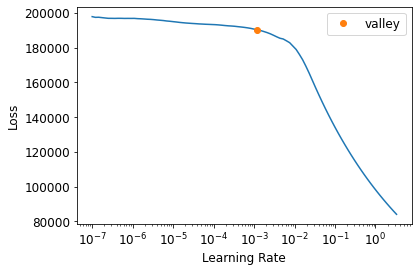

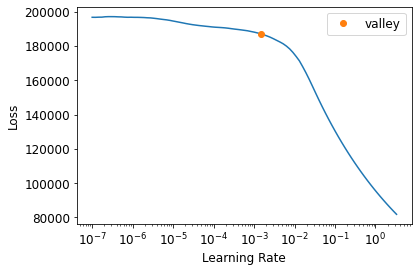

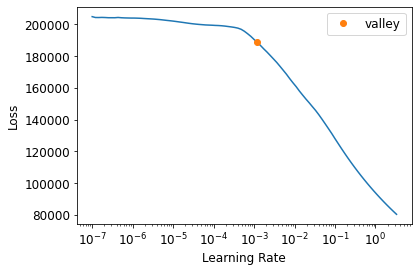

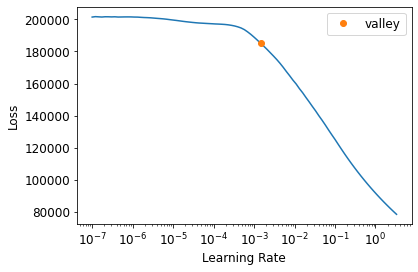

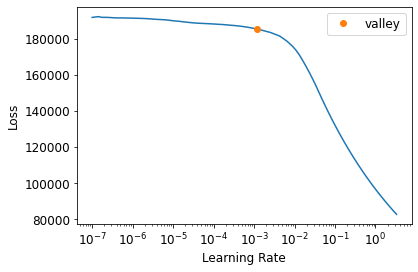

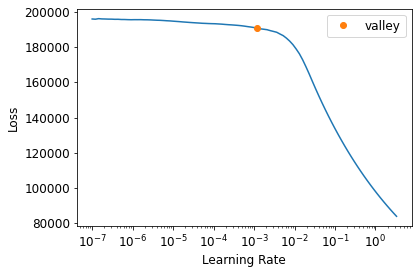

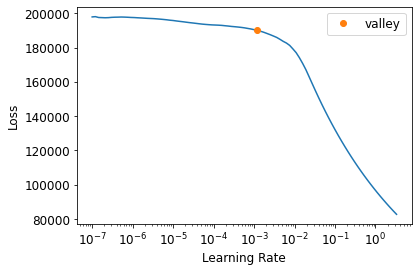

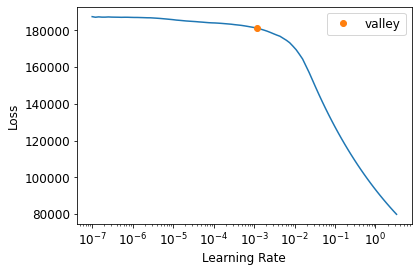

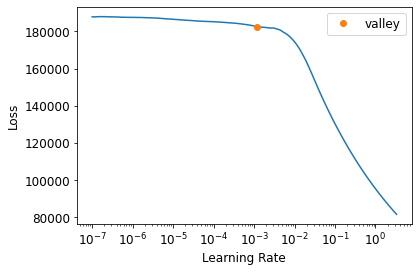

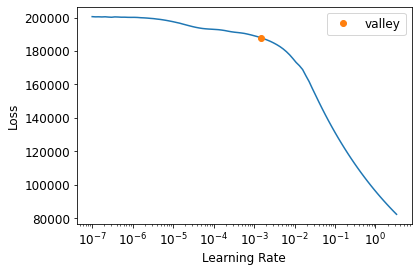

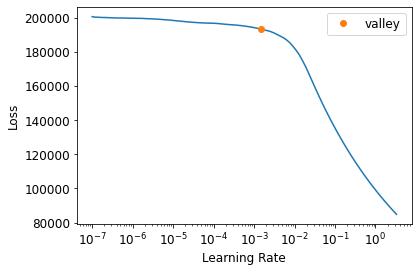

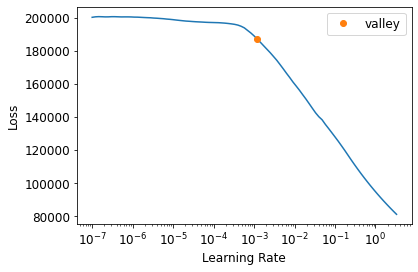

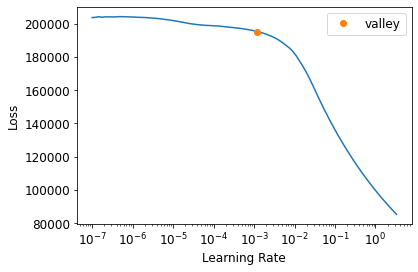

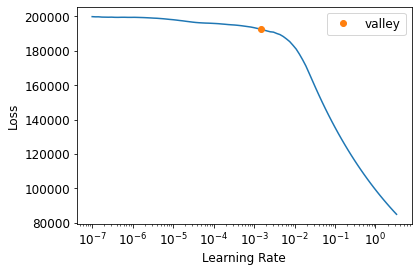

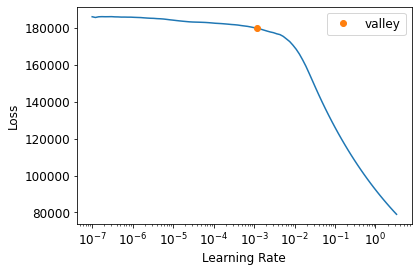

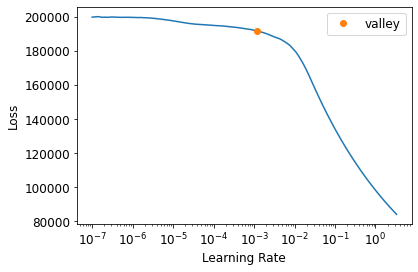

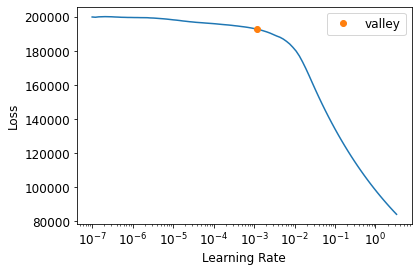

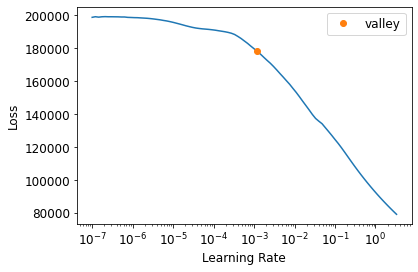

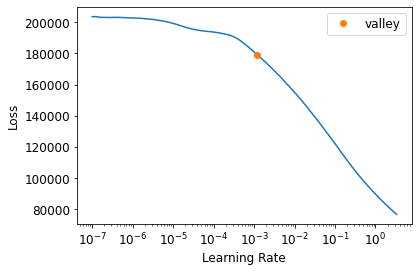

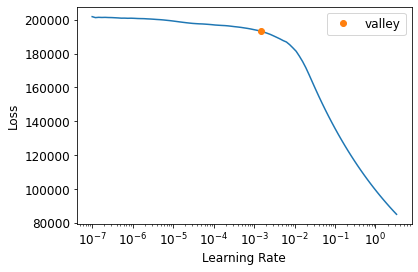

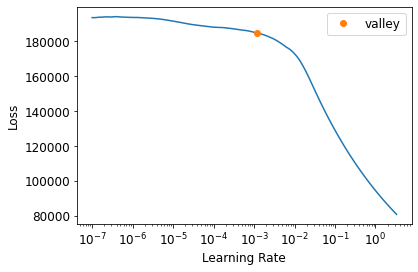

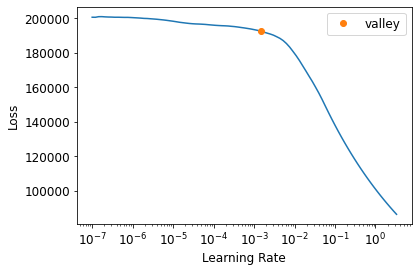

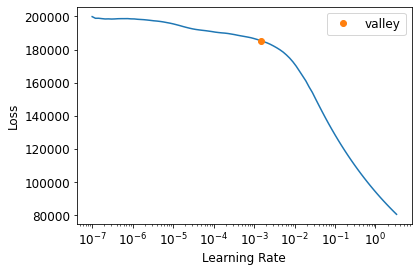

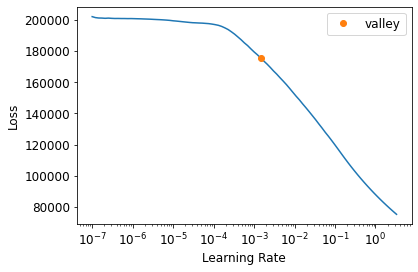

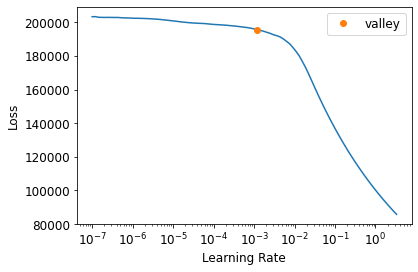

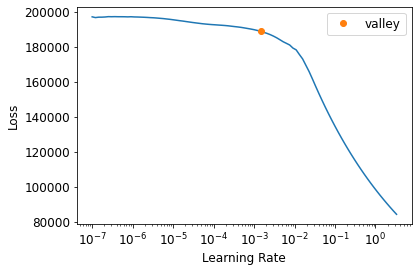

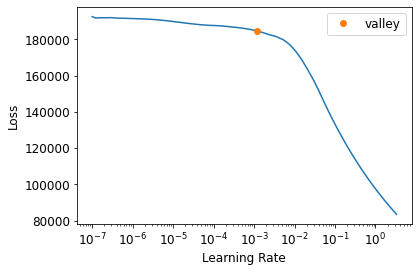

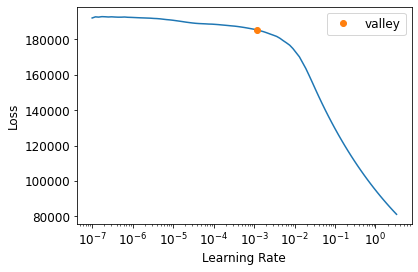

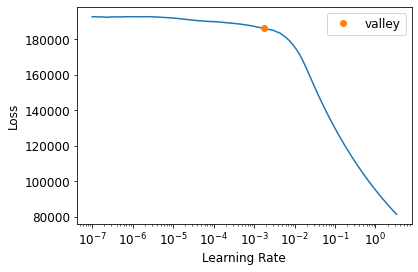

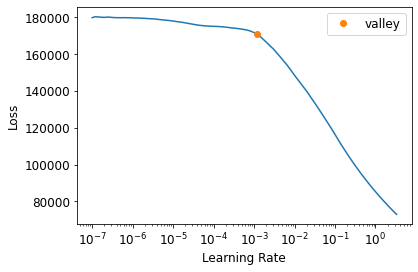

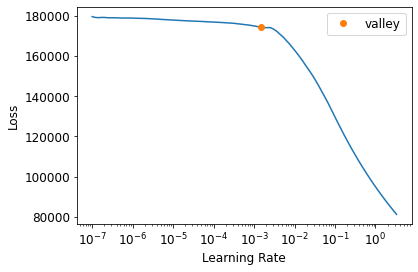

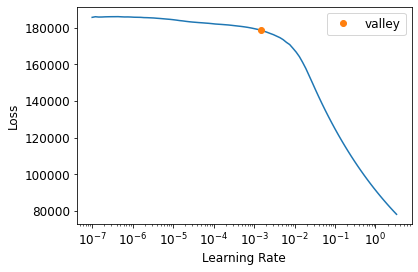

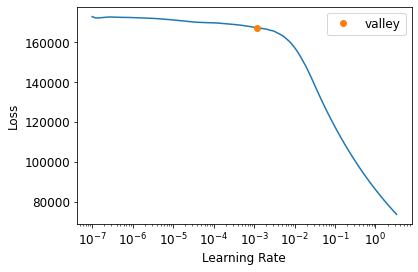

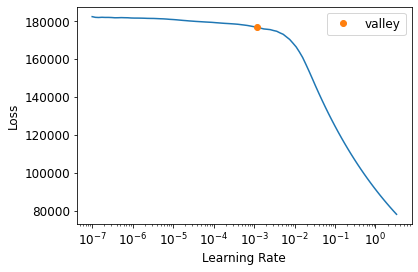

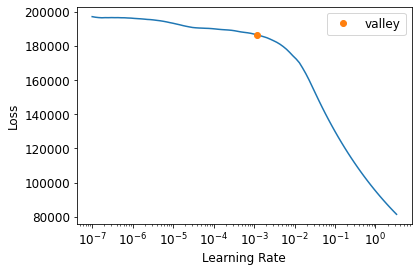

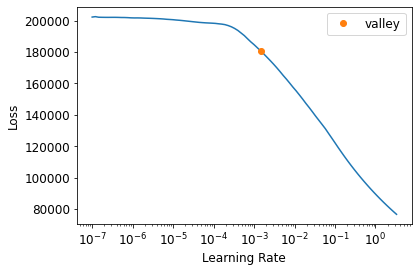

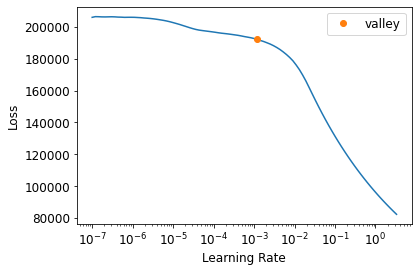

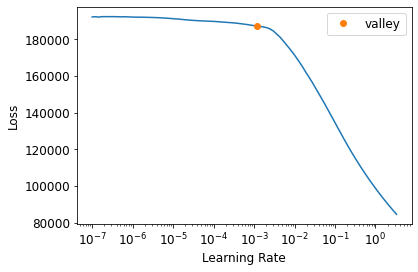

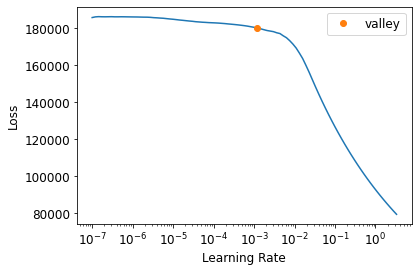

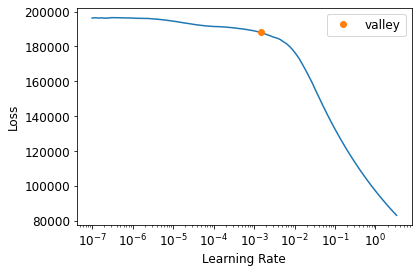

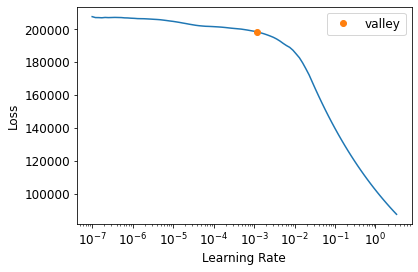

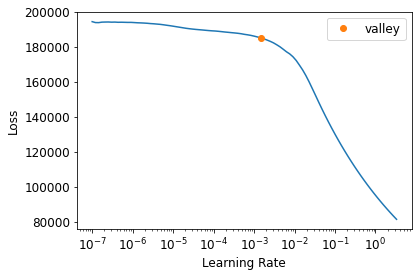

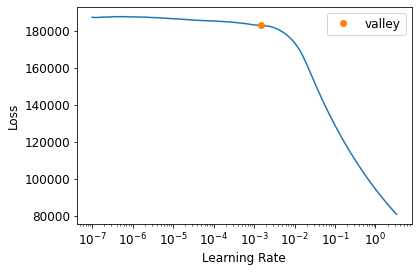

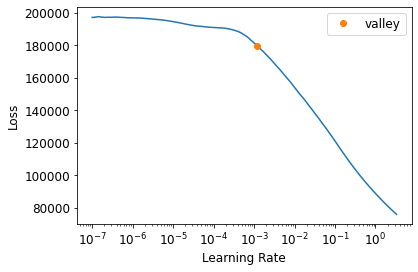

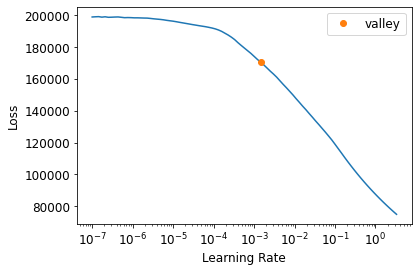

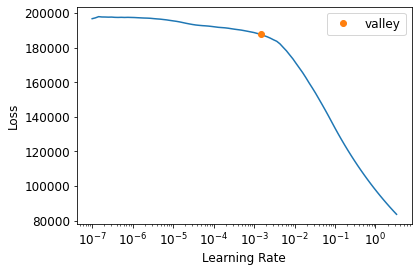

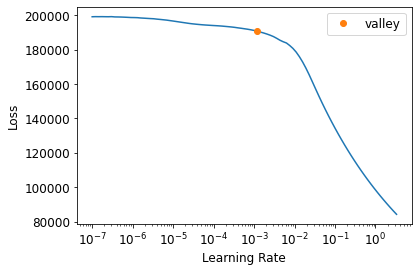

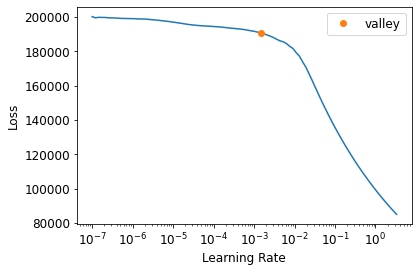

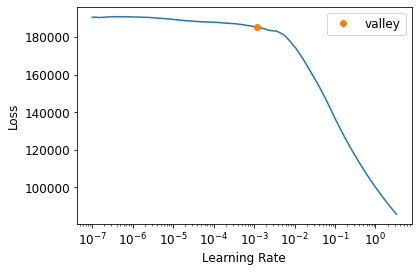

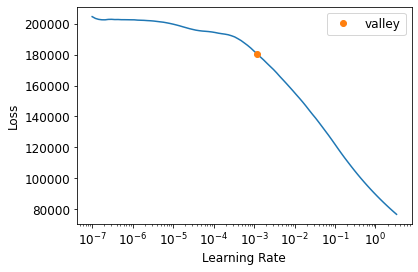

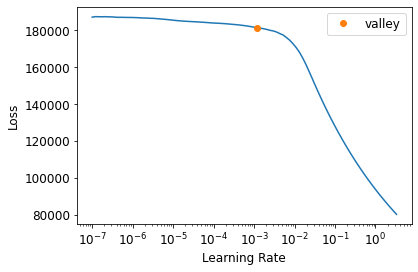

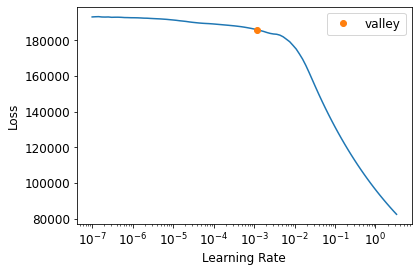

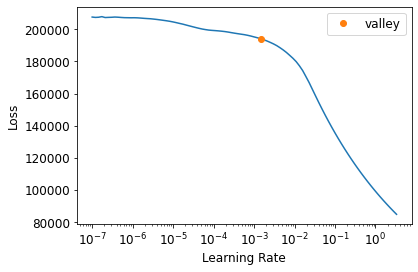

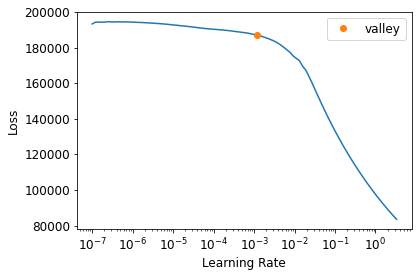

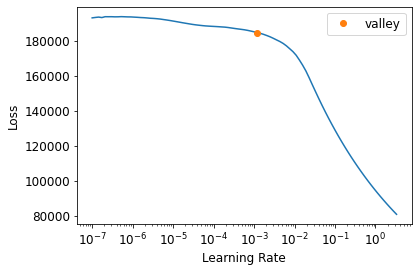

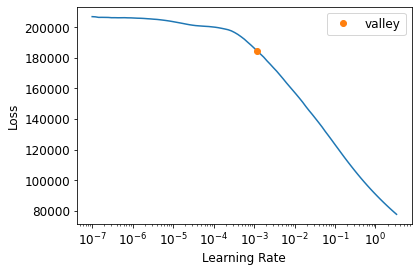

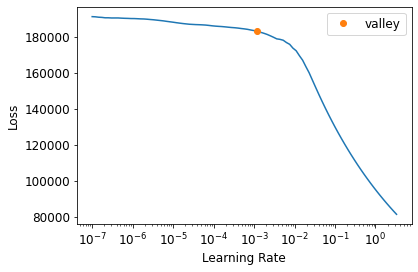

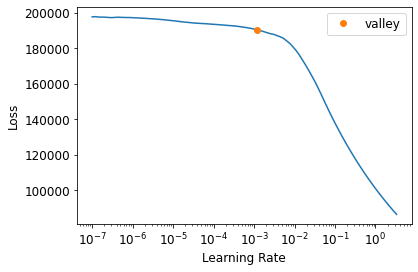

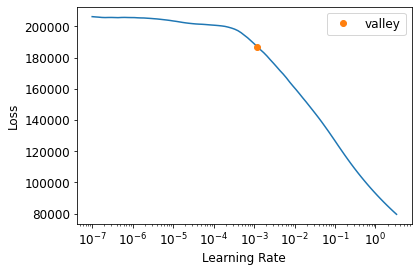

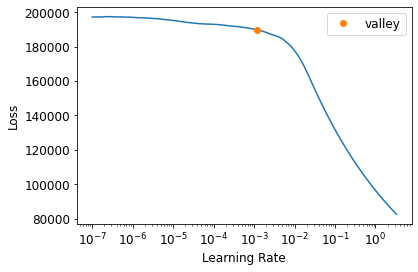

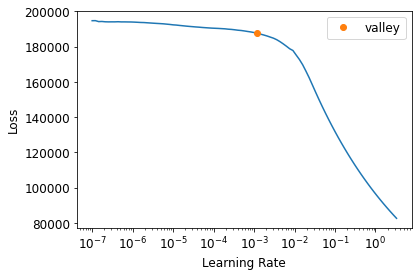

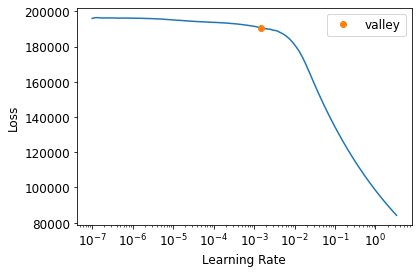

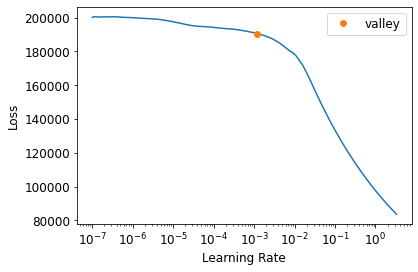

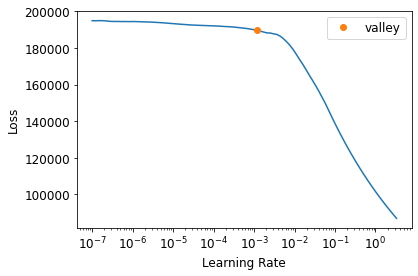

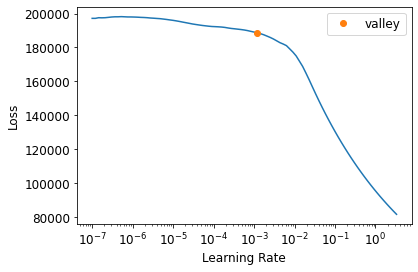

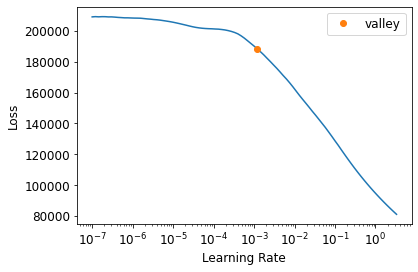

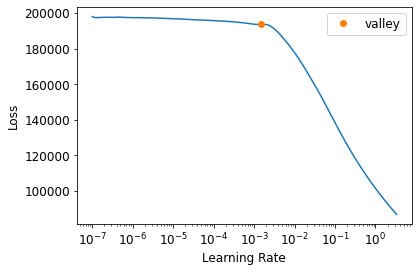

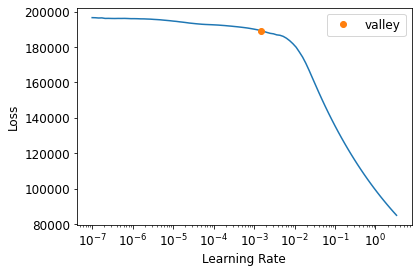

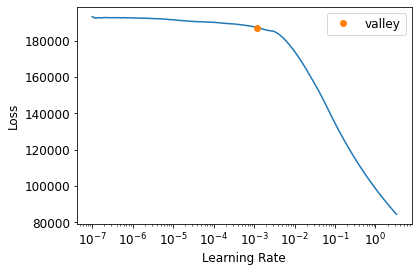

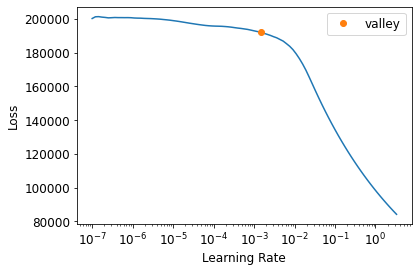

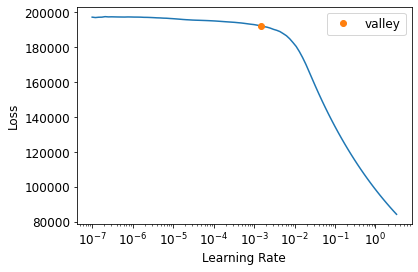

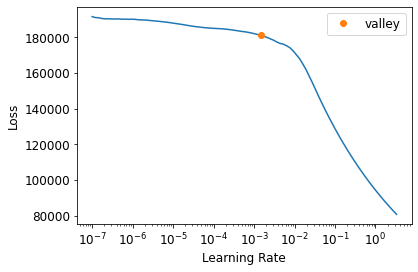

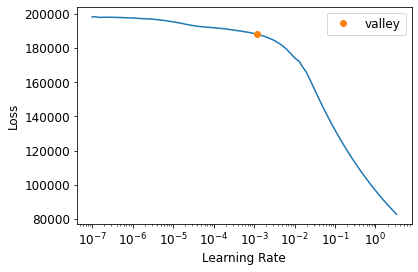

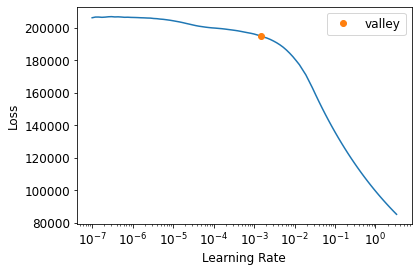

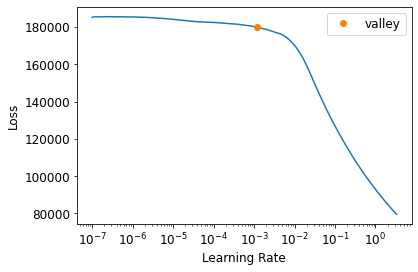

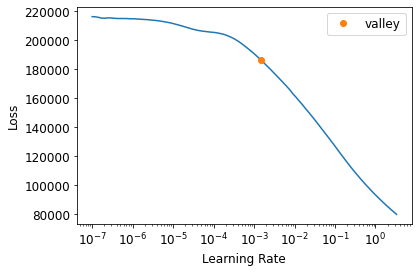

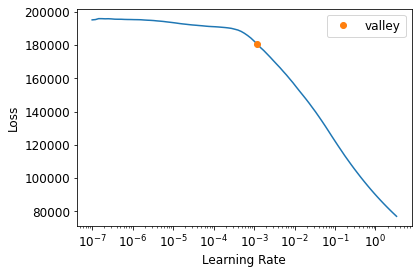

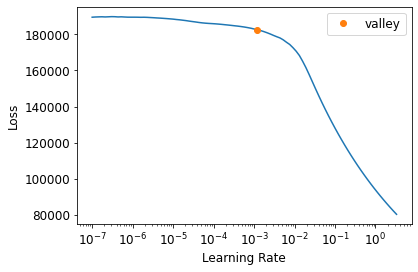

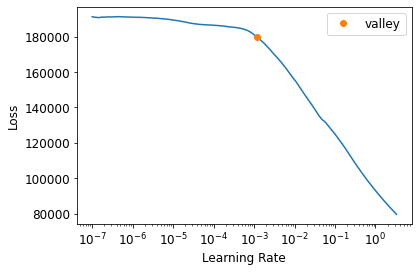

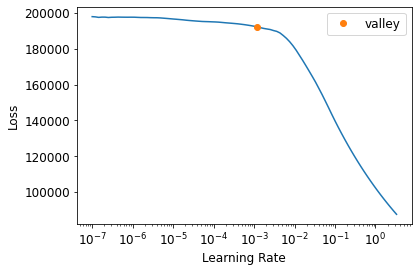

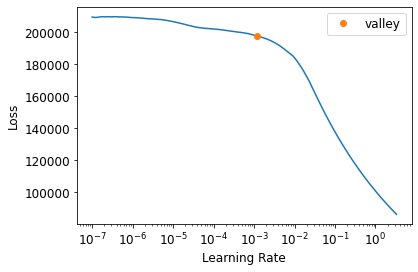

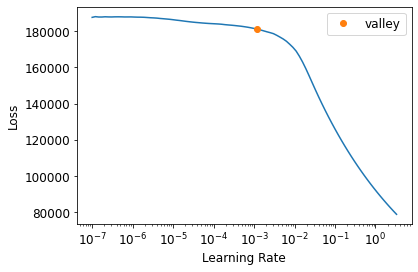

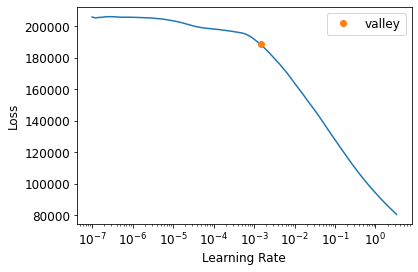

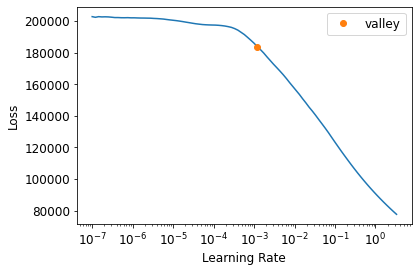

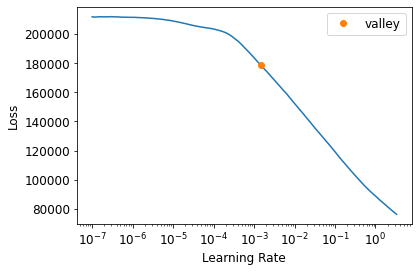

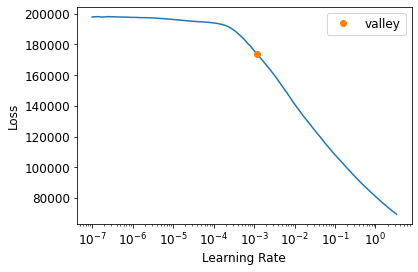

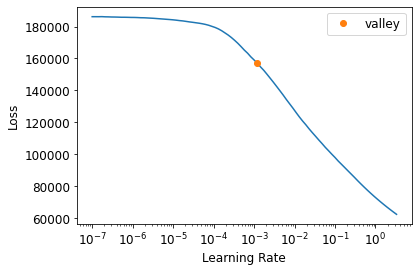

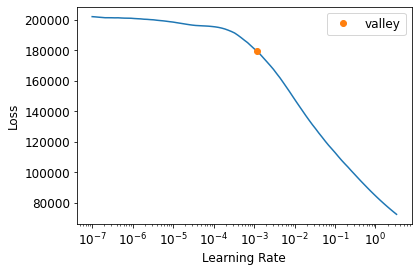

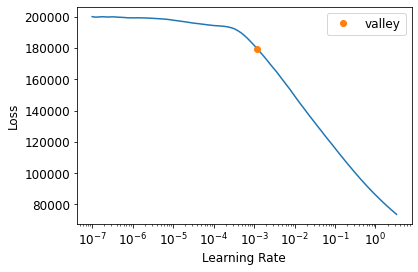

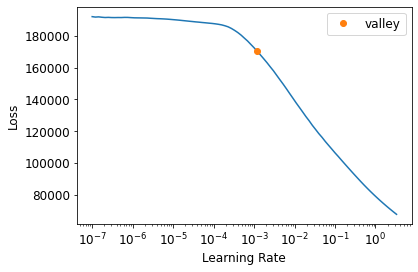

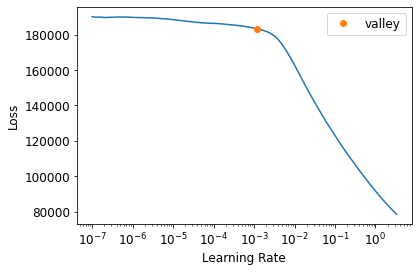

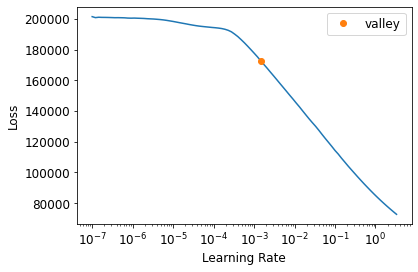

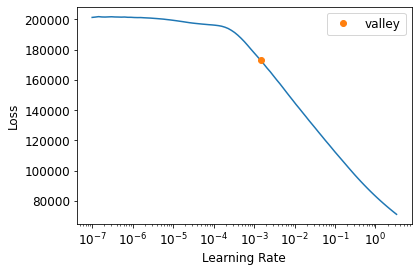

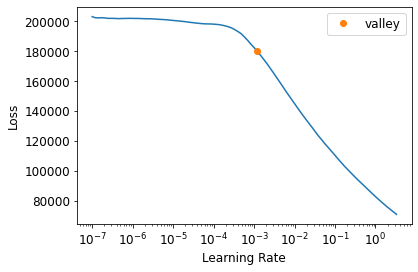

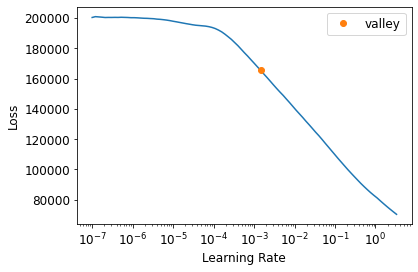

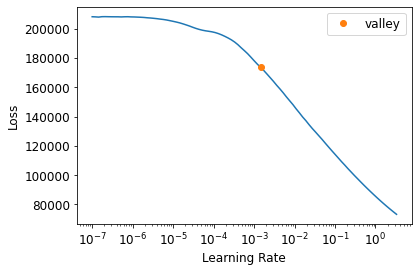

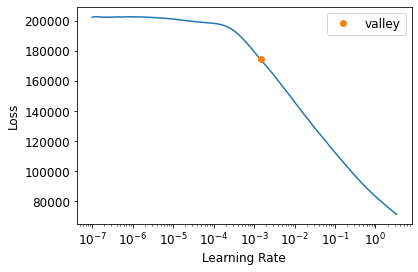

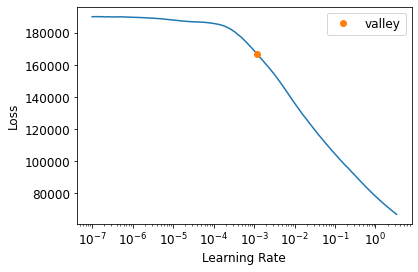

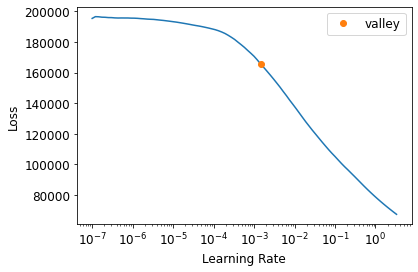

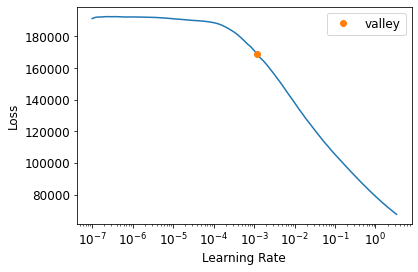

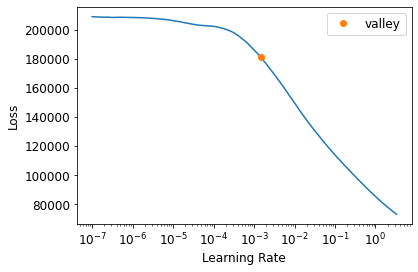

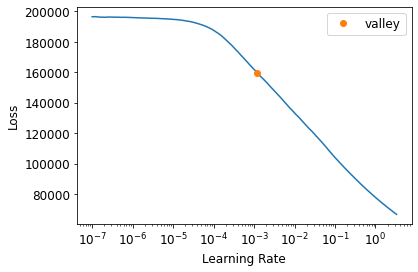

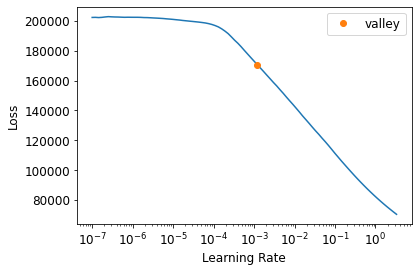

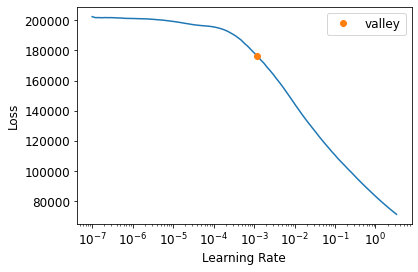

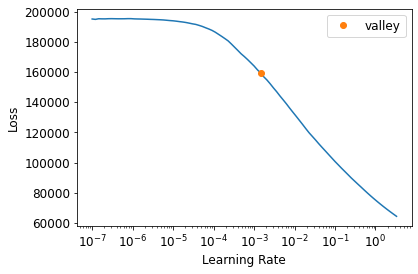

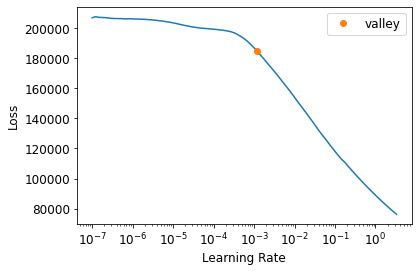

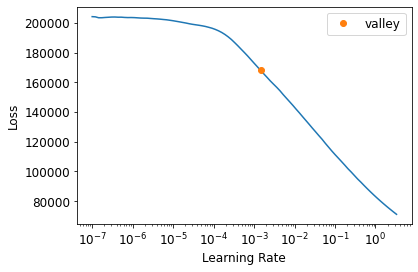

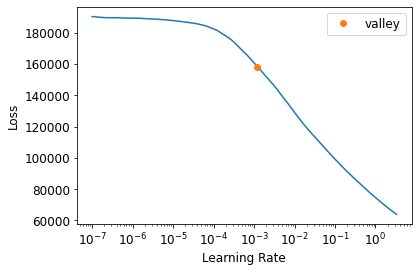

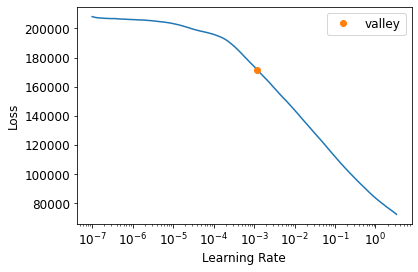

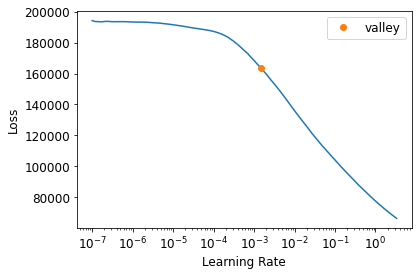

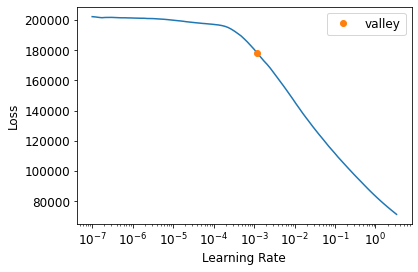

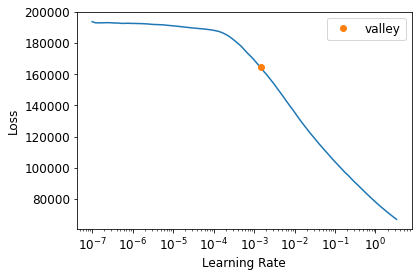

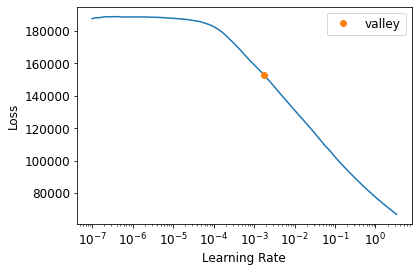

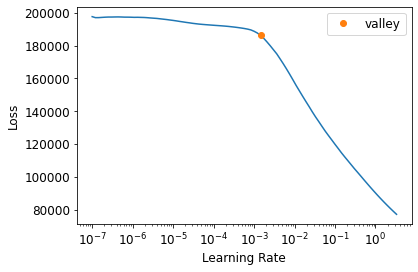

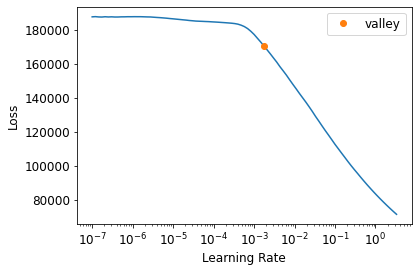

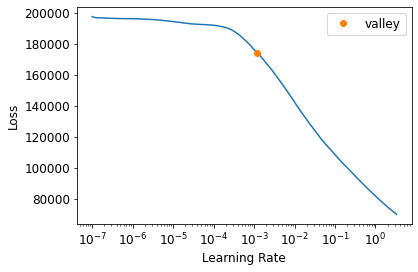

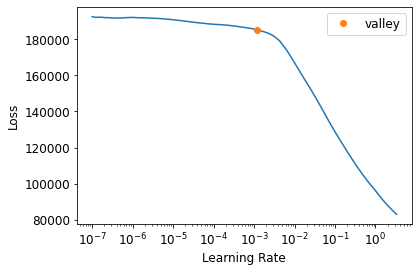

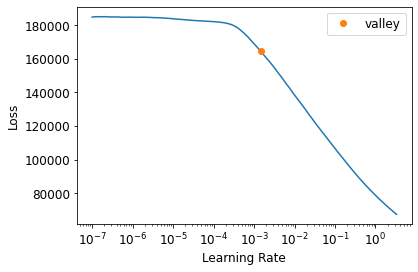

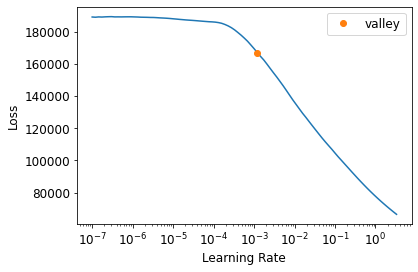

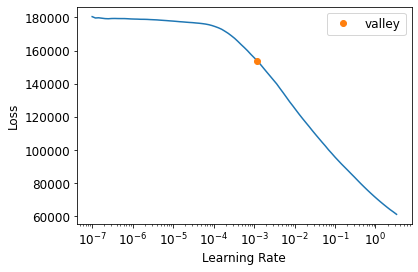

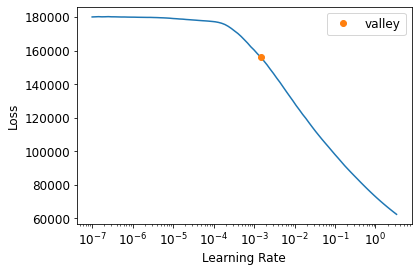

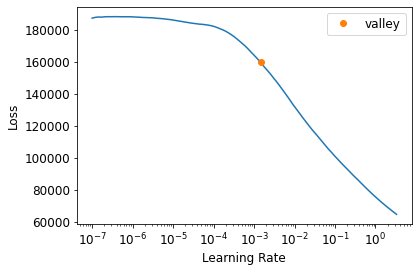

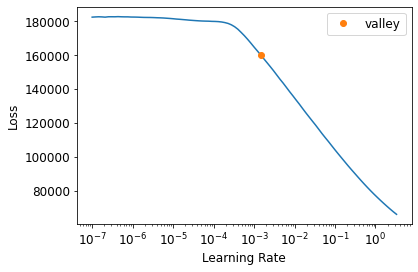

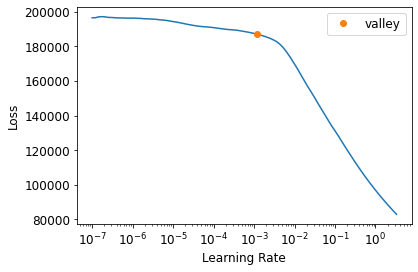

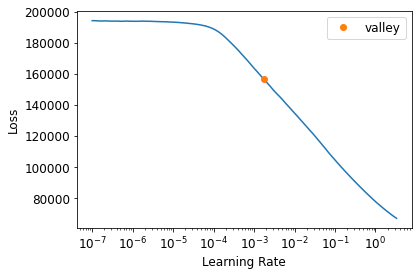

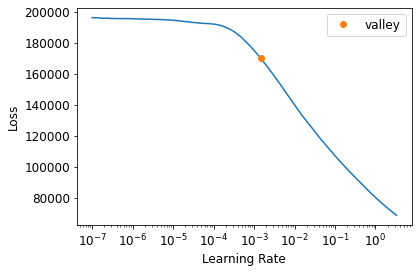

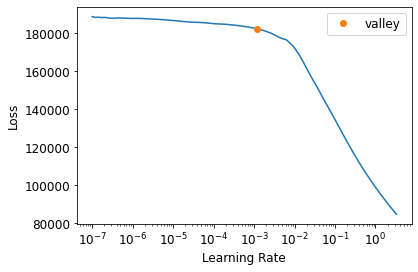

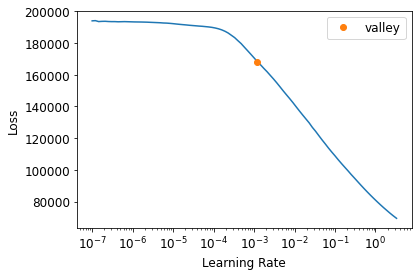

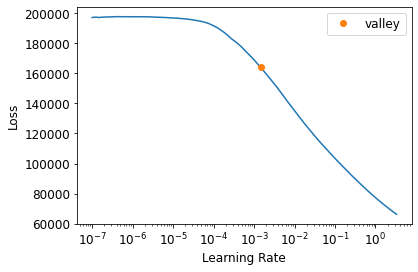

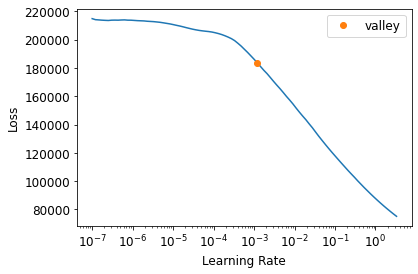

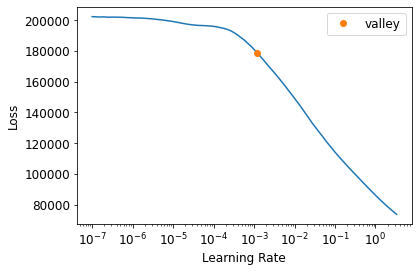

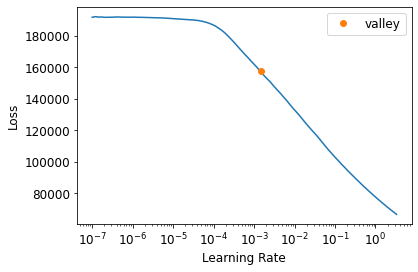

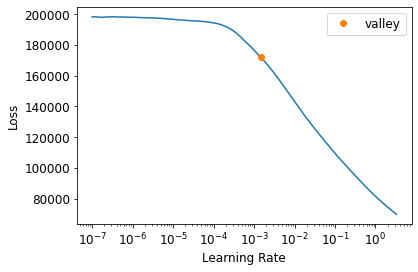

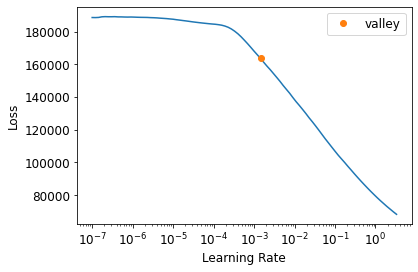

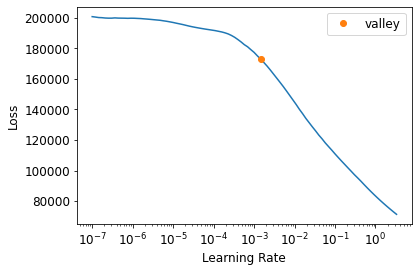

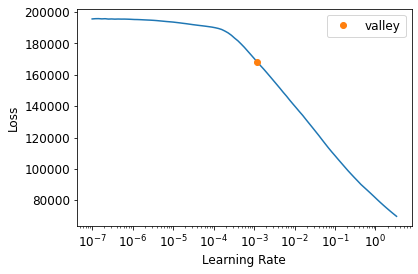

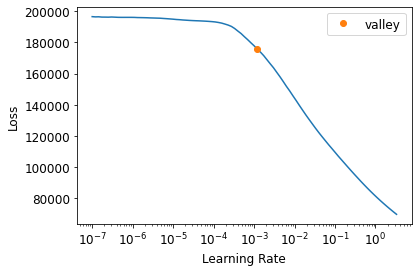

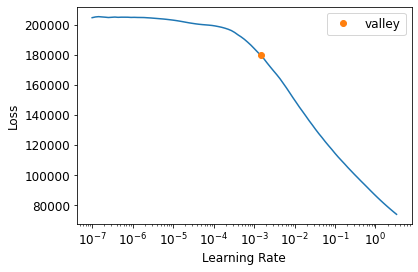

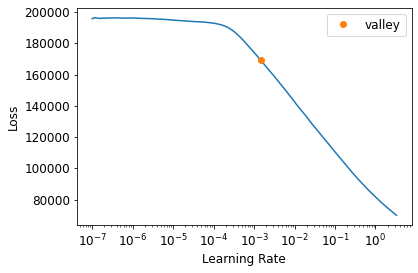

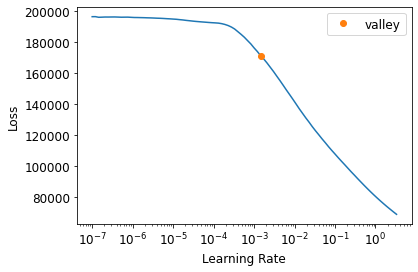

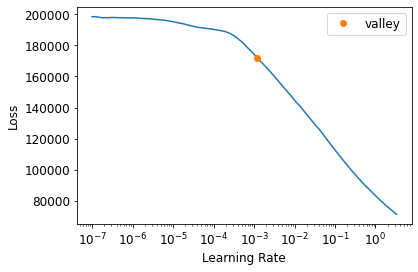

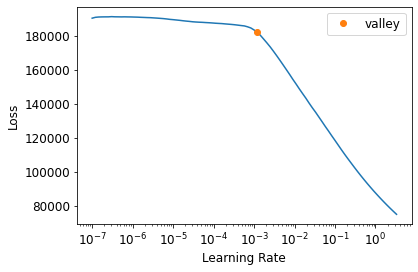

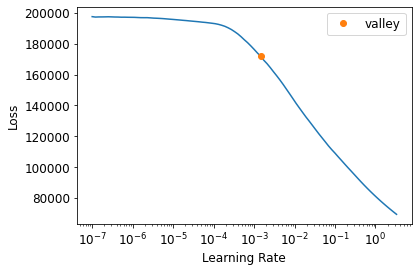

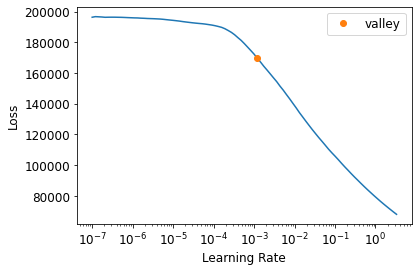

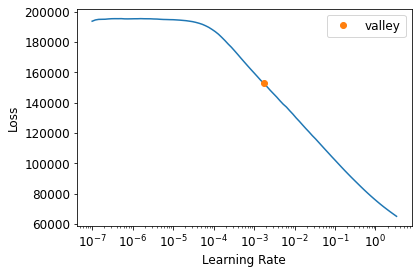

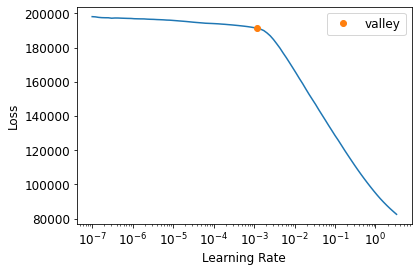

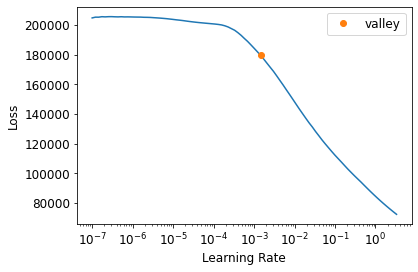

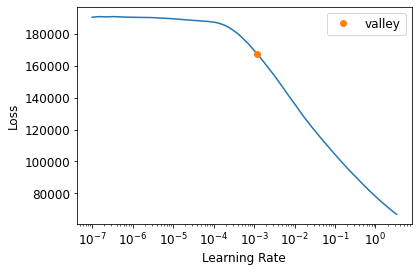

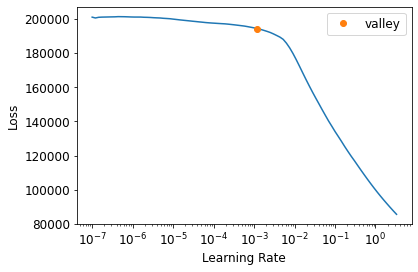

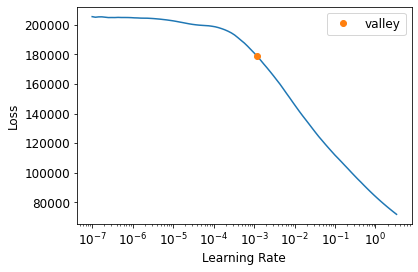

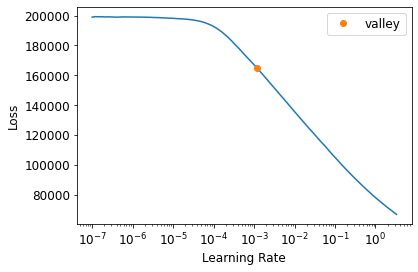

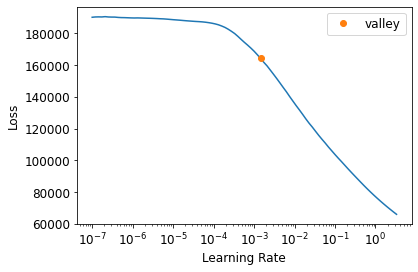

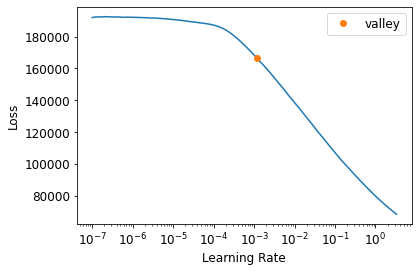

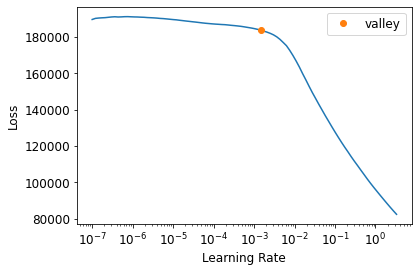

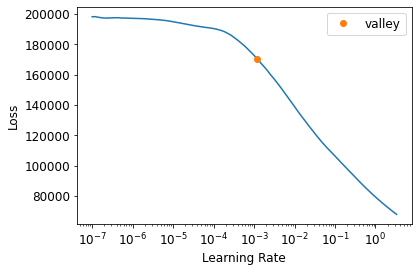

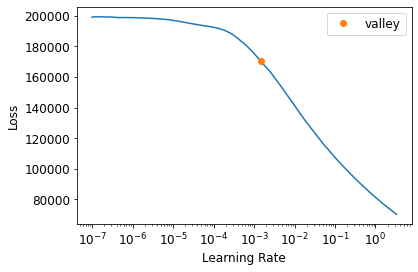

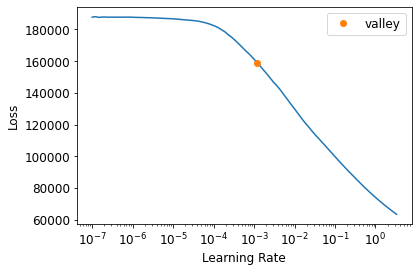

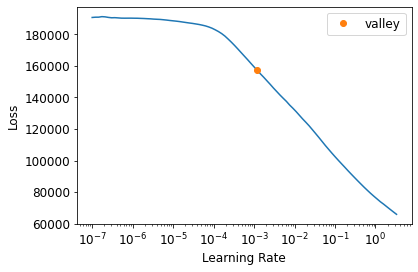

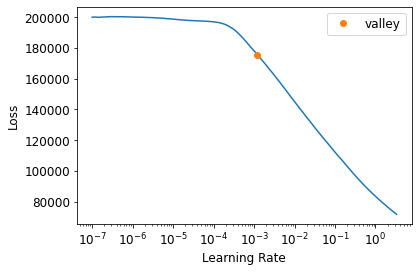

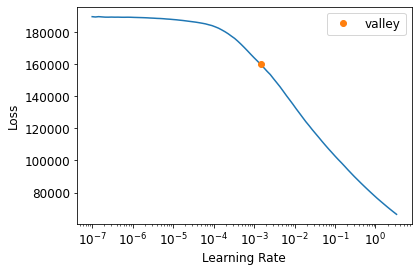

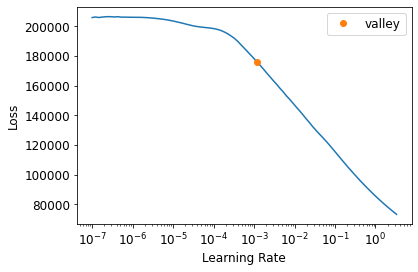

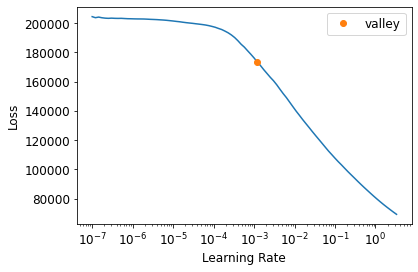

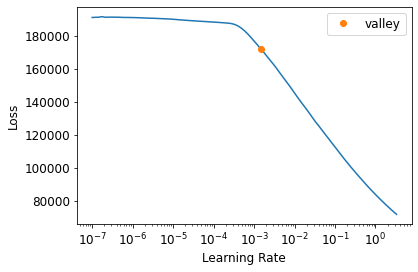

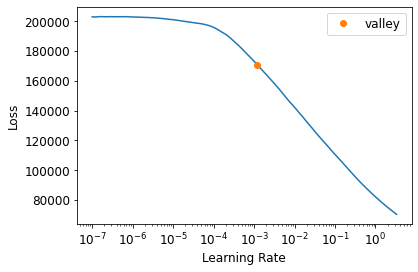

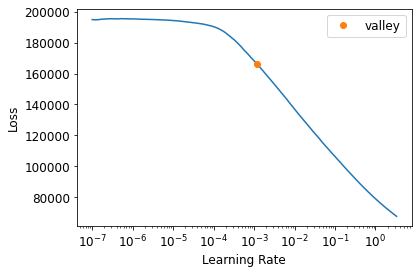

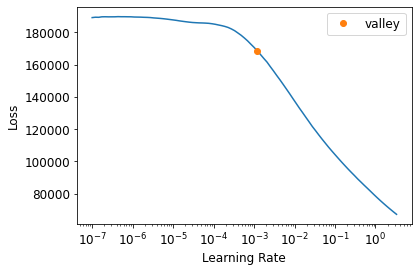

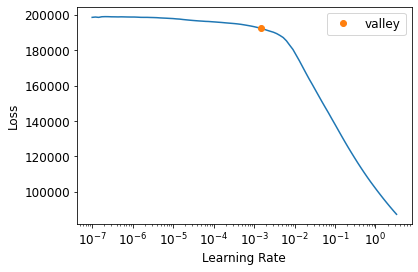

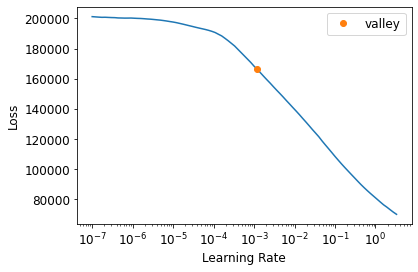

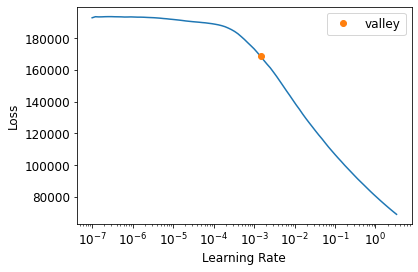

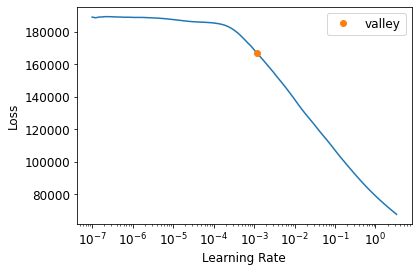

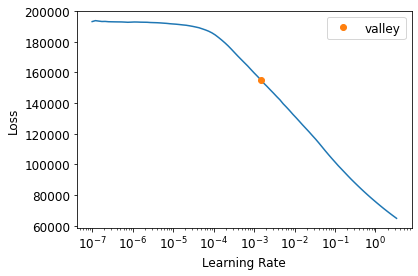

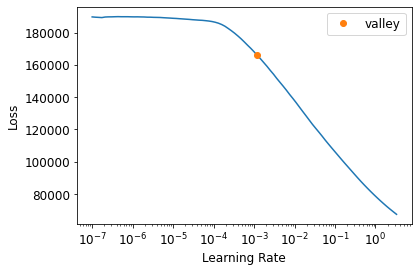

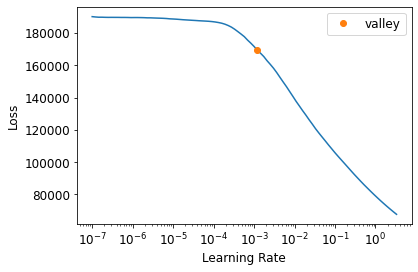

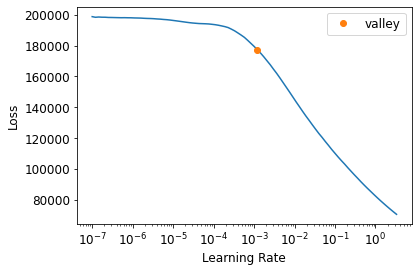

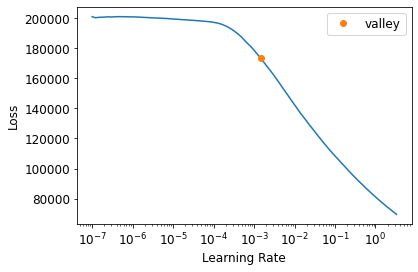

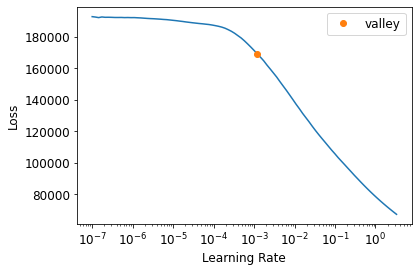

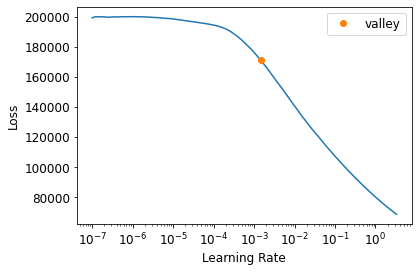

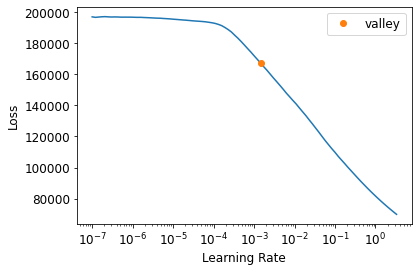

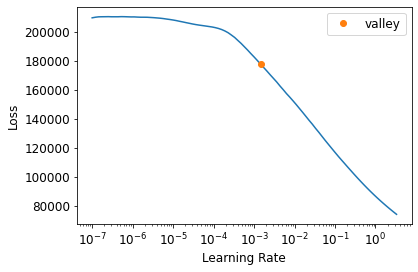

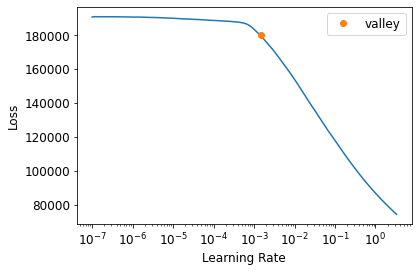

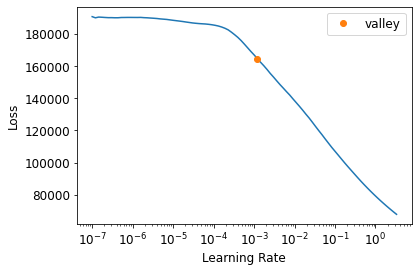

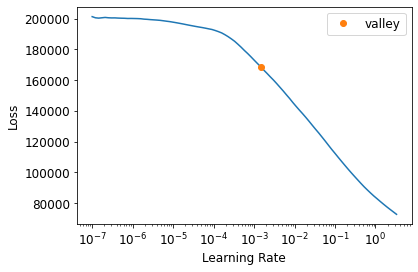

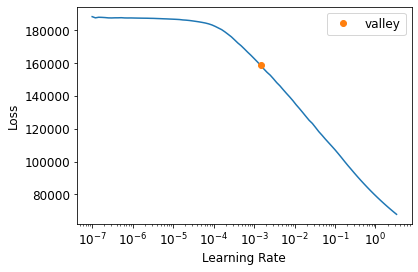

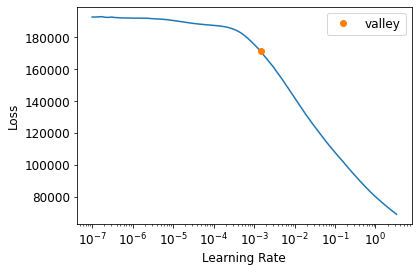

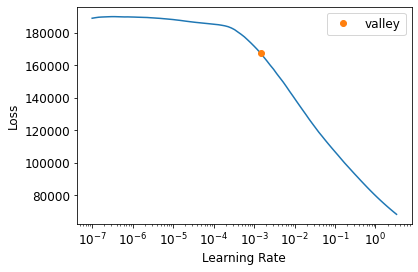

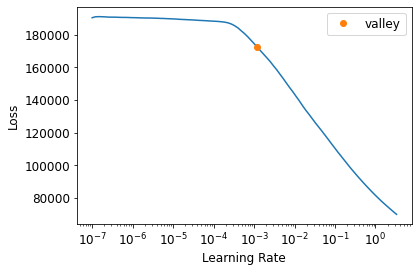

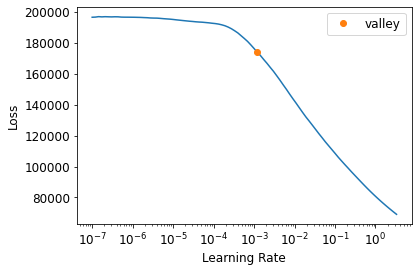

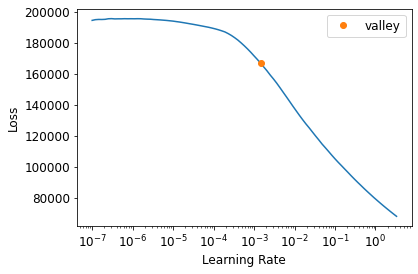

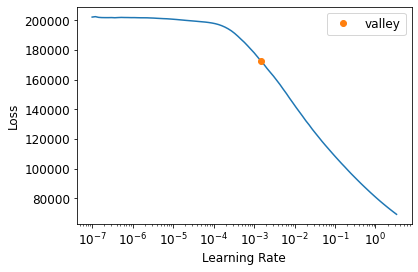

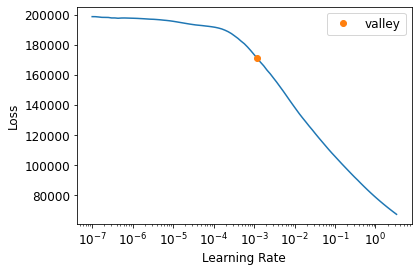

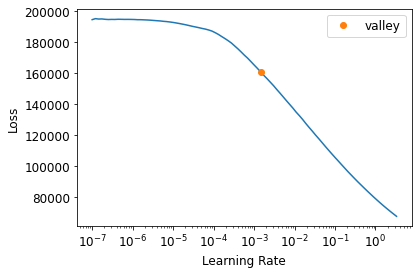

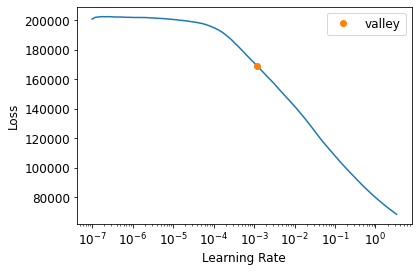

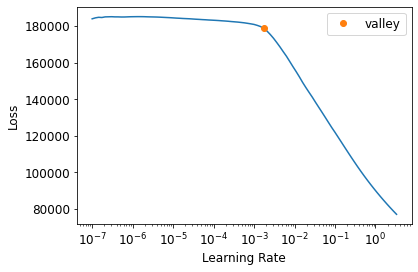

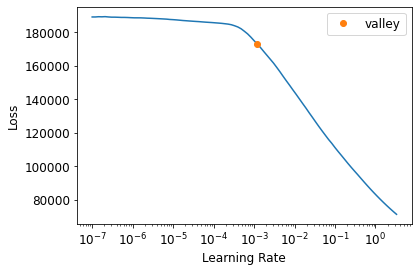

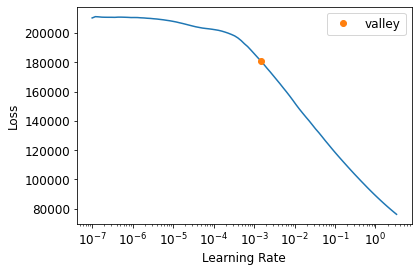

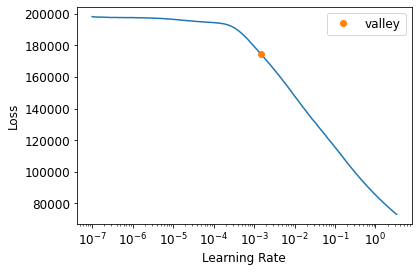

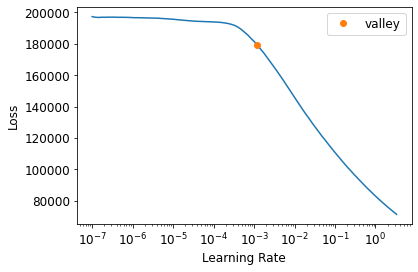

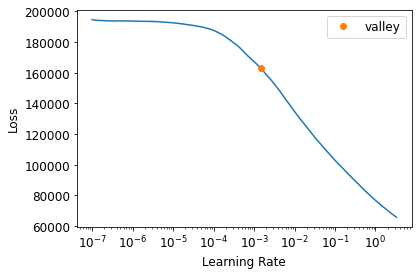

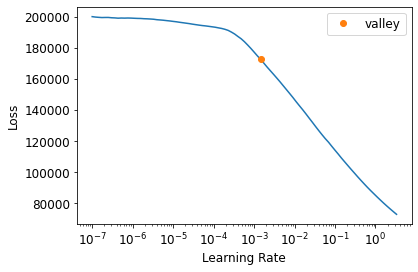

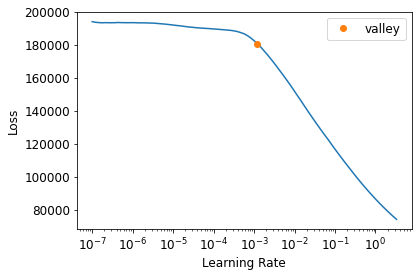

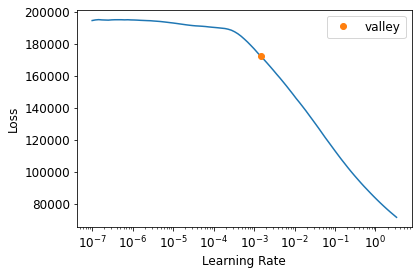

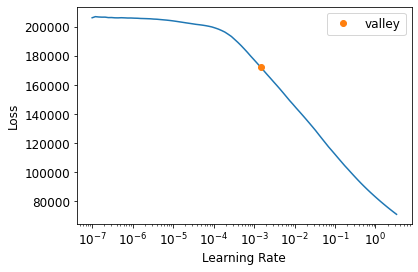

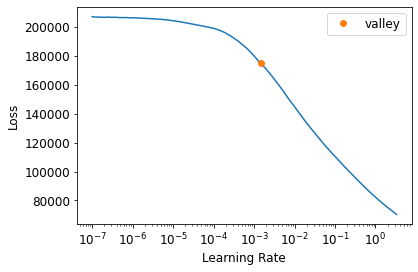

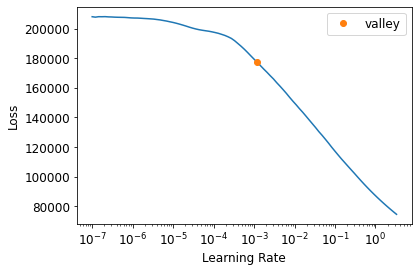

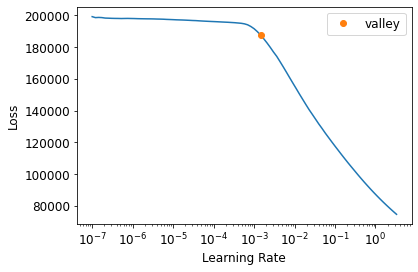

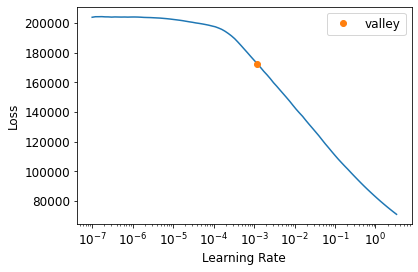

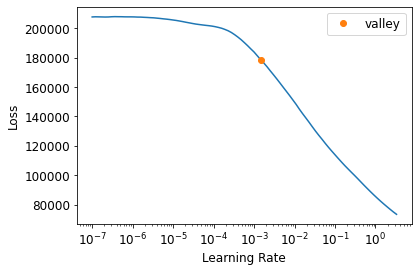

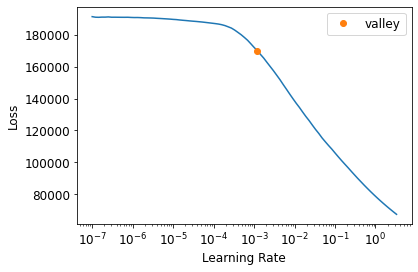

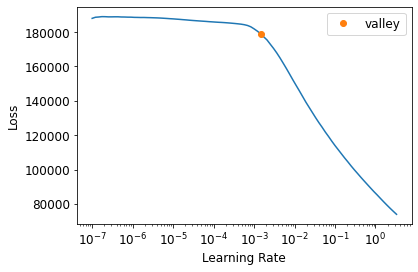

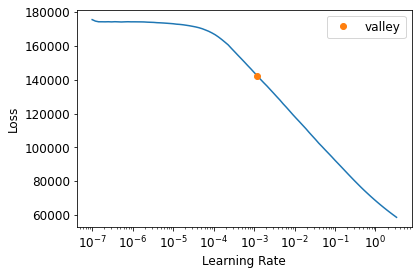

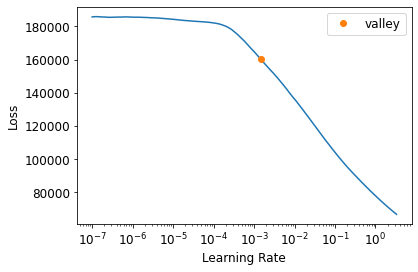

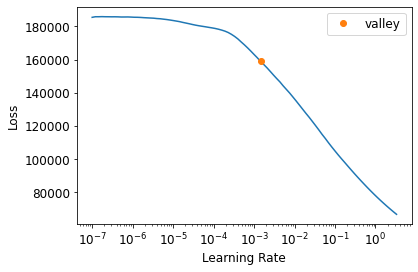

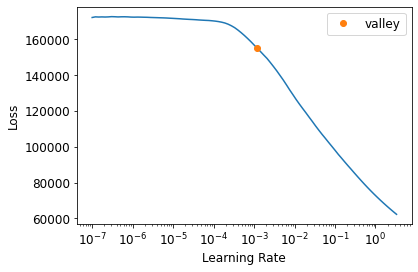

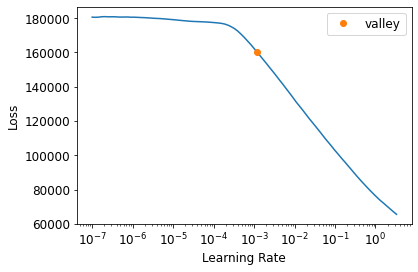

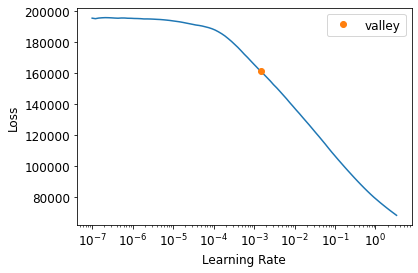

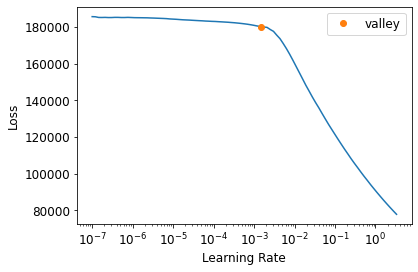

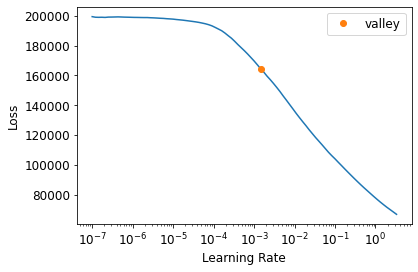

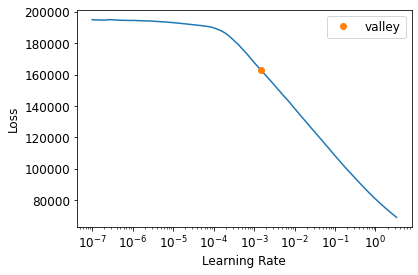

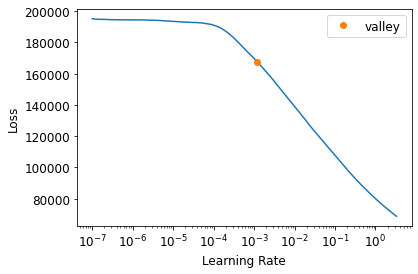

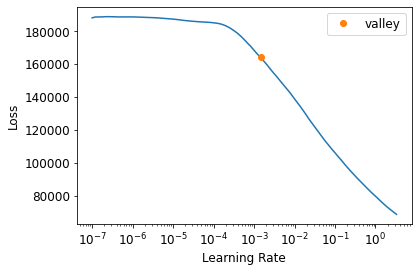

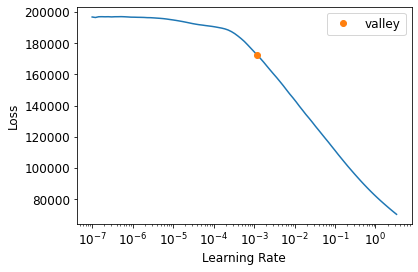

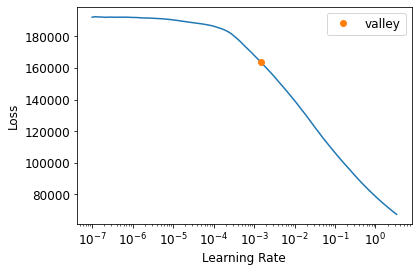

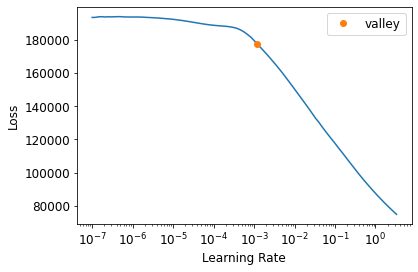

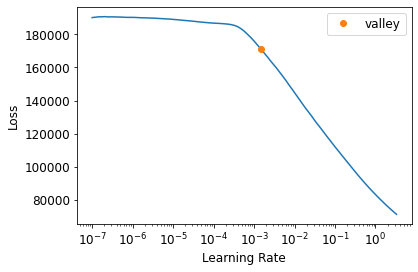

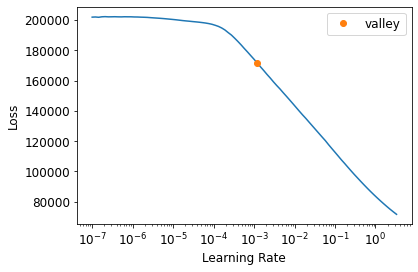

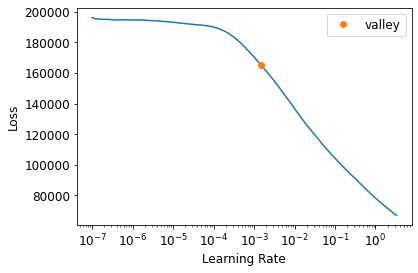

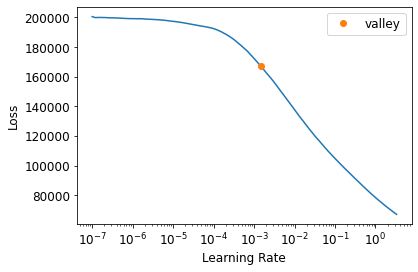

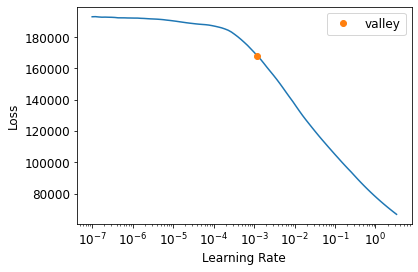

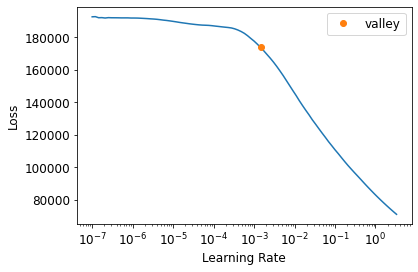

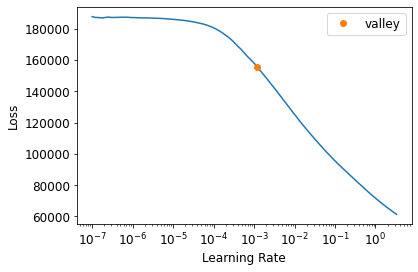

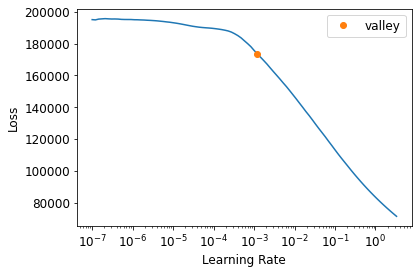

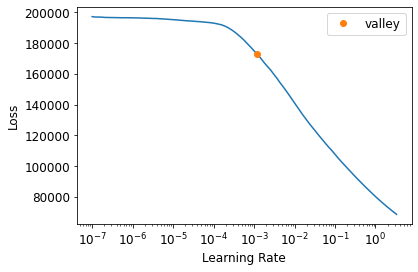

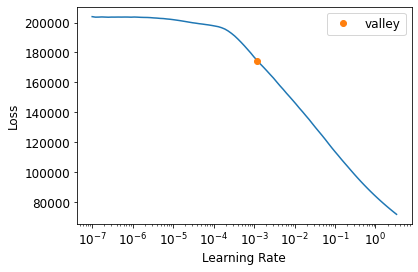

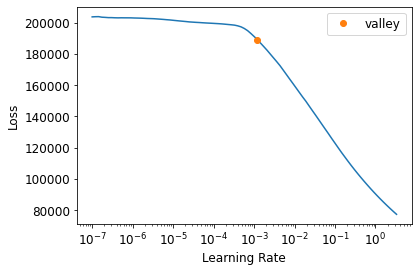

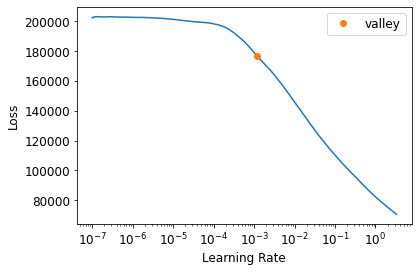

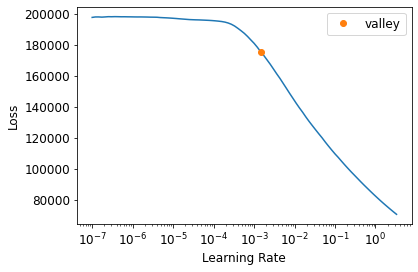

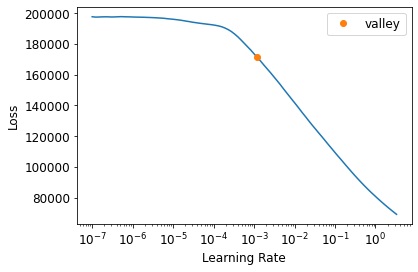

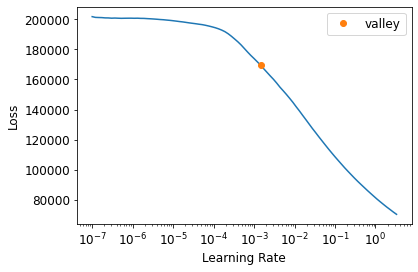

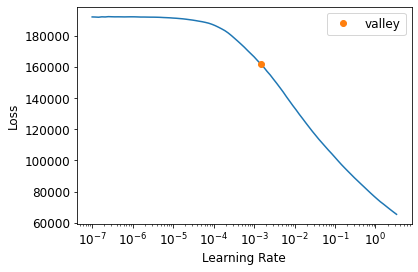

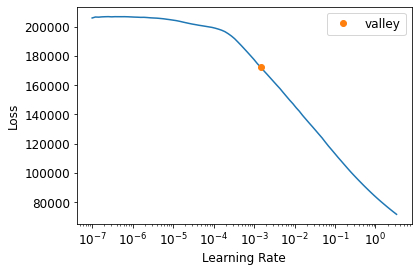

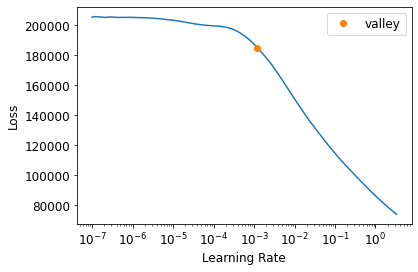

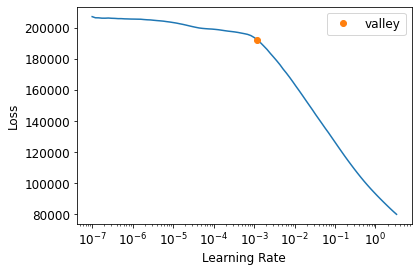

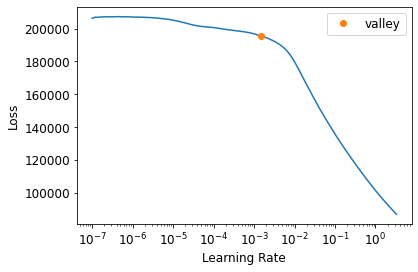

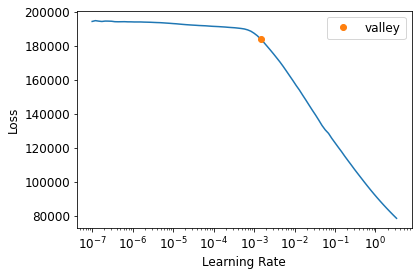

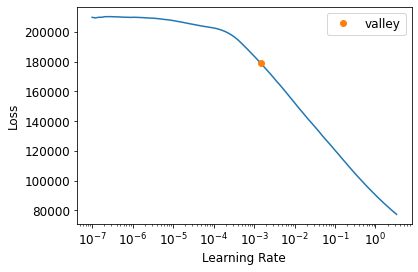

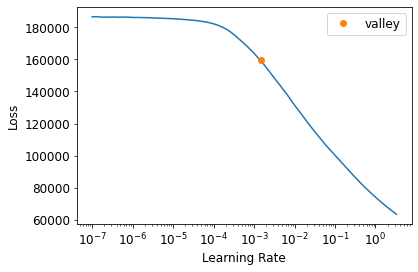

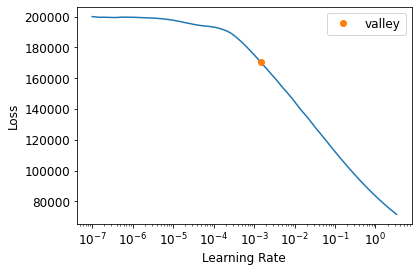

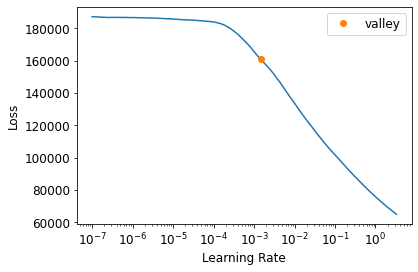

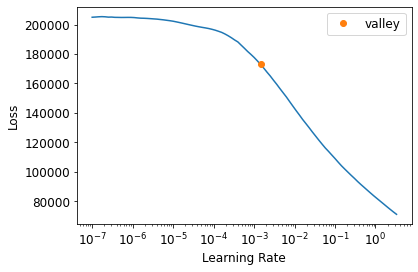

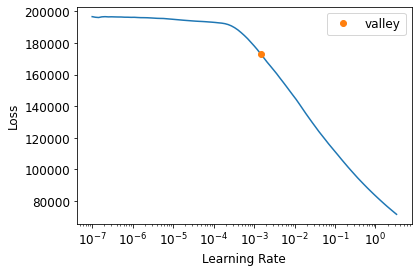

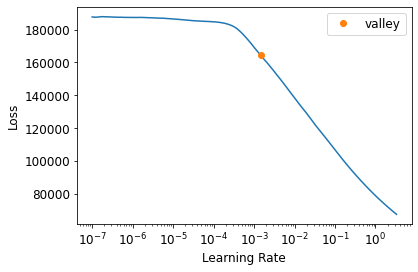

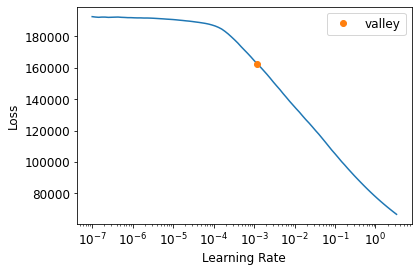

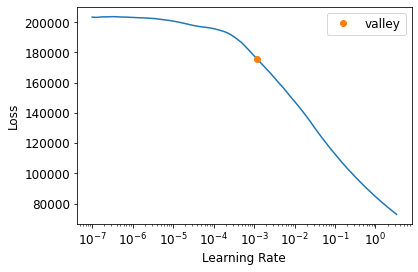

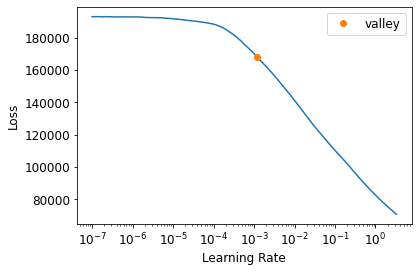

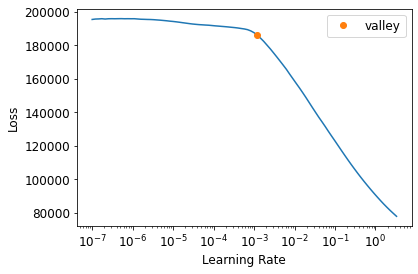

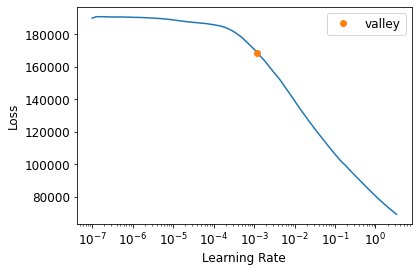

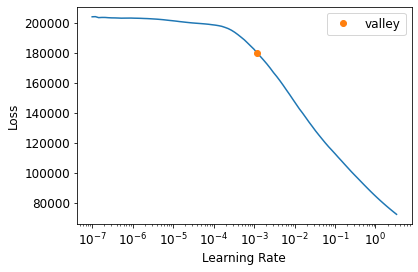

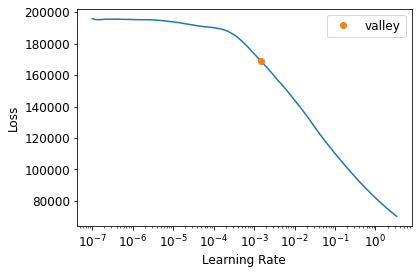

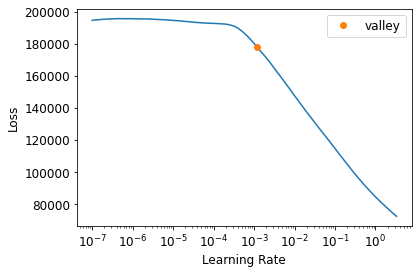

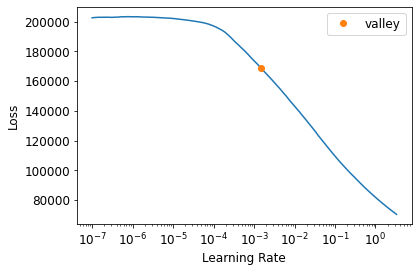

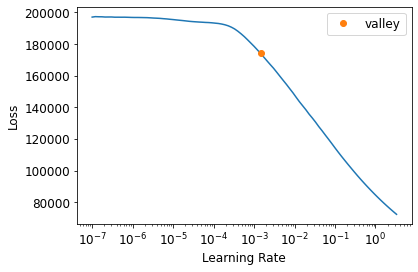

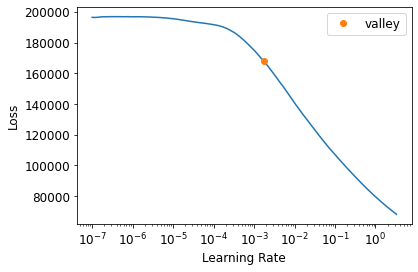

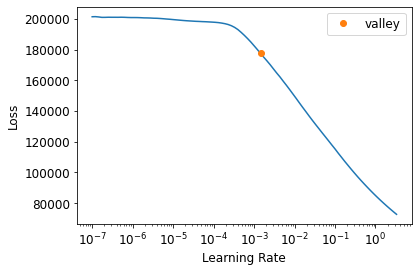

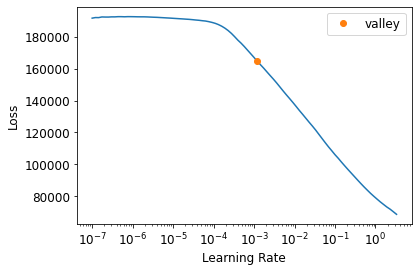

In [11]:
# Loop through each simulation
for sim_index, sim in enumerate(sim_label):
    # Print simulation
    print(sim)
    
    # Get featues/variables for each simulation
    sim_data = df[sim_features[sim_index]]
       
    # Loop through each year
    for yr in years:
        
        # Print year
        print(yr)
        
        # Copy simulation data
        train = sim_data.copy()
        
        # Get test data. Test set is data for year of interest.
        test = train[(train['year'] == yr)]
        
        # Use this to add test predictions 
        test_original = test.copy()
        
        # Remove test data from train data
        train = train.loc[~((train['year'] == yr)),:]
        
        # Remove 'year' from datasets as it is not needed now
        train = train.drop('year', axis=1)
        test = test.drop('year', axis=1)
        
        # X,y test dataset
        #X_test, y_test = test.drop(dep_var,axis=1), test[dep_var]
        
        # Set number of k-folds 
        n_folds = 5 
    
        # Empty array to store test predictions for each k-fold   
        preds_test_ar = np.ones((n_folds,len(test)))
        
        # Set y range needed for the prediction
        min_y, max_y = train[dep_var].min(), train[dep_var].max()*1.2
        
        # Define splits into k-folds
        kf = KFold(n_splits=n_folds, random_state=42, shuffle=True) 
        kf.get_n_splits(train) # returns the number of splitting iterations in the cross-validator
    
        index_count  = 0
        for train_index, valid_index in kf.split(train):
            index_count += 1
            print(index_count-1)
                 
            # Generate split for valid set
            splits = (list(train_index),list(valid_index))

            # Split data by continuous categorical features
            cont,cat = cont_cat_split(train, max_card=9000, dep_var=dep_var)
            
            # Set tabular object for the model
            to_nn = TabularPandas(train, 
                                  procs_nn, 
                                  cat, cont, 
                                  y_names=dep_var, splits=splits, 
                                  inplace=True, 
                                  reduce_memory=True,
                                  y_block=RegressionBlock())
            
            # Print some useful information
            print('length of cont '+str(len(cont)))
            print('length of cat '+str(len(cat)))   # Should be zero
            print('length of train set '+str(len(to_nn.train)))
            print('length of valid set '+str(len(to_nn.valid)))

            # Set mini-batch size
            #dls = to_nn.dataloaders(bs=5000)
            dls = to_nn.dataloaders(bs=1024)

            # Show mini-batch size
            #dls.valid.show_batch()
             
            # Model configuation
            layers=[1000,500]
            config = tabular_config(ps=[0.001,0.01],
                                    y_range=(min_y,max_y))
            
            # Create tabular learner
            # Set y range, number of activations in the two hidden layers, loss function, and metric
            learn = tabular_learner(dls,
                                    layers=layers, 
                                    config=config,
                                    n_out=1,
                                    loss_func=MSELossFlat(),
                                    metrics=rmse) 
            
            # Plot learning rate finder
            #learn.lr_find()
            lr_steep = learn.lr_find()

            # Train with a 30 of epochs with defined learning rate
            #learn.fit_one_cycle(30, 1e-3, wd=0.2) 
            learn.fit_one_cycle(30, lr_steep, wd=0.2) 

            # plot losses
            #learn.recorder.plot_loss()

            # Get prediction from valid set
            preds,targs = learn.get_preds()
            print('Valid RMSE = '+ str(r_mse(preds,targs)))

            # Save model
            #learn.export('nn_model')
            #del learn

            # Load model 
            #learn = load_learner('nn_model')
            
            
            # Test model on test set
            dl = learn.dls.test_dl(test)
            raw_test_preds = learn.get_preds(dl=dl)
            preds_test = raw_test_preds[0].numpy().T[0]
            
            print('Test RMSE = '+ str(r_mse(preds_test,
                                            test[dep_var].values))
                 )

            # Store test fire count predictions    
            preds_test_ar[index_count-1,:] = preds_test

            # Average and save fire count predictions
            if index_count-1 == 4:  

                # Average test predictions across folds and save 
                test_original['preds'] = np.round(preds_test_ar.mean(axis=0))
                test_original.to_csv(outpath + 'test_preds_'+sim+'_'+str(n_folds)+'folds_'+str(yr)+'.csv', index=False)
     